# Encoding and Tokenizer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import re
import collections
from collections import Counter
import math

def load_corpus(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

def tokenize(text):
    return re.findall(r'\b\w+\b|[\s\.,!?;]', text)

def build_vocab(tokens, max_vocab_size=10000):
    token_freqs = Counter(tokens)
    sorted_tokens = sorted(token_freqs.items(), key=lambda x: (-x[1], x[0]))
    # Ensure special tokens are included
    vocab = {"[PAD]": 0, "[UNK]": 1, "[CLS]": 2, "[SEP]": 3, "[MASK]": 4}
    for token, _ in sorted_tokens[:max_vocab_size - len(vocab)]:
        vocab[token] = len(vocab)
    return vocab

def cosine_annealing_scheduler(optimizer, initial_lr, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return 0.5 * (1. + math.cos(math.pi * progress)) 

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def combined_loss(output, target, model, l2_reg_strength=1.0, l1_reg_strength=0.0):
    task_loss = nn.CrossEntropyLoss()(output, target)  
    regularization_loss = 0

    for param in model.parameters():
        if isinstance(param, nn.Parameter):  
            regularization_loss += param.pow(2).sum() * l2_reg_strength  # L2
            regularization_loss += param.abs().sum() * l1_reg_strength  # L1

    return task_loss + regularization_loss

# Encoding Transformer Code

class AdaptiveDropoutLayer(nn.Module):
    def __init__(self, init_dropout_rate=0.1):
        super(AdaptiveDropoutLayer, self).__init__()
        # Use logit transformation for stability
        self.log_alpha = nn.Parameter(torch.tensor(math.log(init_dropout_rate / (1 - init_dropout_rate))).float())

    def forward(self, x):
        p = torch.sigmoid(self.log_alpha)
        # Convert p from a tensor to a float
        p_value = p.item()  # This extracts the scalar value as a Python float
        return nn.functional.dropout(x, p=p_value, training=self.training)


class AdaptiveWeightDecayOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, init_l2_strength=0.01):
        super().__init__(params, {'lr': lr})
        self.log_l2_strength = nn.Parameter(torch.tensor(math.log(init_l2_strength)).float())

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = torch.exp(self.log_l2_strength)  
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay) 
                p.update(d_p, group['lr']) 

        return loss

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_len = max_len

        # Create positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add a batch dimension (B x T x C)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: Tensor of shape [Batch Size, Sequence Length, Embedding Dimension]
        # Adjust positional encoding to match the input size and device
        pe = self.pe[:, :x.size(1)]
        # Assuming x is on the correct device, pe will be automatically aligned to the same device
        return pe


class MultiHeadLinformerAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, k=None):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.k = k if k is not None else embed_dim // num_heads  # Projection dimension per head

        self.key_projections = nn.Linear(embed_dim, self.k * num_heads)
        self.value_projections = nn.Linear(embed_dim, self.k * num_heads)
        self.out_projection = nn.Linear(self.k * num_heads, embed_dim)

    def forward(self, query):
        batch_size, seq_len, _ = query.size()
        
        # Project keys and values
        keys = self.key_projections(query)
        values = self.value_projections(query)
        
        # Reshape into [batch_size, num_heads, seq_len, k]
        keys = keys.reshape(batch_size, seq_len, self.num_heads, self.k).transpose(1, 2)
        values = values.reshape(batch_size, seq_len, self.num_heads, self.k).transpose(1, 2)
        
        # Calculate attention (scaled dot-product attention)
        # Scaling by the square root of the depth of the key vectors to prevent large values in the dot product
        # which could push the softmax function into regions where it has extremely small gradients
        keys = keys / (self.k ** 0.5)
        attention_scores = torch.softmax(torch.matmul(keys, values.transpose(-2, -1)), dim=-1)
        
        # Apply attention to values
        out = torch.matmul(attention_scores, values)
        
        # Concatenate heads and project back to original embedding dimension
        out = out.transpose(1, 2).reshape(batch_size, seq_len, self.num_heads * self.k)
        out = self.out_projection(out)
        
        return out


class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_seq_len= 512):
        self.tokenizer = tokenizer
        self.texts = texts
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoded_text = self.tokenizer.encode(text)[:self.max_seq_len]         
        labels = encoded_text.copy()  # Copy encoded text for labels

        # Apply dynamic masking
        masked_indices = np.random.rand(len(encoded_text)) < 0.15
        for i in range(len(encoded_text)):
            if masked_indices[i]:
                encoded_text[i] = self.tokenizer.vocab["[MASK]"]

        # Padding
        padding_length = self.max_seq_len - len(encoded_text)
        attention_mask = [1] * len(encoded_text) + [0] * padding_length
        encoded_text += [self.tokenizer.vocab["[PAD]"]] * padding_length
        labels += [-100] * padding_length  # Use -100 for padding positions

        return {
            "input_ids": torch.tensor(encoded_text, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long)
        }


class AdaptiveEmbeddingLayer(nn.Module):
    def __init__(self, vocab,  vocab_size, freq_threshold, large_embed_dim, small_embed_dim, max_seq_len):
        super(AdaptiveEmbeddingLayer, self).__init__()
        self.vocab = vocab
        self.vocab_size = vocab_size
        self.freq_threshold = freq_threshold
        self.large_embed_dim = large_embed_dim
        self.small_embed_dim = small_embed_dim
        self.max_seq_len = max_seq_len

        self.split_vocab(vocab, freq_threshold)  

        self.frequent_embeddings = nn.Embedding(num_embeddings=len(self.frequent_vocab), embedding_dim=large_embed_dim)
        self.infrequent_embeddings = nn.Embedding(num_embeddings=len(self.infrequent_vocab), embedding_dim=small_embed_dim)
        self.infrequent_projection = nn.Linear(small_embed_dim, large_embed_dim)
        self.positional_embeddings = PositionalEncoding(large_embed_dim, max_seq_len)


    def split_vocab(self, vocab, freq_threshold):
        token_counts = [(token, count) for token, count in vocab.items()]
        token_counts.sort(key=lambda x: -x[1])  # Sort by frequency
        split_point = next(i for i, (_, count) in enumerate(token_counts) if count < freq_threshold)
        
        self.frequent_vocab = dict(token_counts[:split_point])
        self.infrequent_vocab = dict(token_counts[split_point:])

    def forward(self, token_ids):
        device = token_ids.device
        seq_len = token_ids.size(1)
        batch_size = token_ids.size(0)  # Obtain batch size from token_ids tensor

        # Initialize embeddings tensor
        embeddings = torch.zeros(token_ids.shape[0], seq_len, self.large_embed_dim, device=device)

        # Map token_ids to indices for frequent and infrequent vocab
        frequent_indices = torch.zeros_like(token_ids)
        infrequent_indices = torch.zeros_like(token_ids)
        
        for token_id, index in self.vocab.items():
            mask = token_ids == token_id
            if token_id in self.frequent_vocab:
                # Map to index in frequent_vocab
                frequent_indices[mask] = self.frequent_vocab[token_id]
            elif token_id in self.infrequent_vocab:
                # Map to index in infrequent_vocab
                infrequent_indices[mask] = self.infrequent_vocab[token_id]

        # Create masks for frequent and infrequent tokens
        frequent_mask = frequent_indices > 0
        infrequent_mask = infrequent_indices > 0

        # Embed frequent tokens
        if frequent_mask.any():
            frequent_embeddings = self.frequent_embeddings(frequent_indices[frequent_mask])
            embeddings[frequent_mask] = frequent_embeddings

        # Embed and project infrequent tokens
        if infrequent_mask.any():
            infrequent_embeddings = self.infrequent_embeddings(infrequent_indices[infrequent_mask])
            infrequent_embeddings_projected = self.infrequent_projection(infrequent_embeddings)
            embeddings[infrequent_mask] = infrequent_embeddings_projected

        # Apply positional embeddings
        position_ids = torch.arange(0, seq_len, dtype=torch.long, device=device).unsqueeze(0)
        position_embeddings = self.positional_embeddings(position_ids)  # Generate for seq_len

        # Ensure positional embeddings are broadcastable to the embeddings tensor
        # This step may not be necessary if your positional embeddings are already correctly shaped
        if position_embeddings.size(0) != batch_size:
            position_embeddings = position_embeddings.expand(batch_size, -1, -1)

        print(f"Embeddings shape: {embeddings.shape}")
        print(f"Positional embeddings shape: {position_embeddings.shape}")
        embeddings += position_embeddings

        return embeddings



class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward):
        super(TransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadLinformerAttention(embed_dim=d_model, num_heads=nhead)
        self.dropout1 = AdaptiveDropoutLayer()  # Use AdaptiveDropoutLayer
        self.norm2 = nn.LayerNorm(d_model)

        self.ffnn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            AdaptiveDropoutLayer(),  # Use AdaptiveDropoutLayer here as well
            nn.Linear(dim_feedforward, d_model),
        )
        self.dropout2 = AdaptiveDropoutLayer()  # And here
 
    def forward(self, src, src_mask=None):
        src2 = self.norm1(src)
        attn_output = self.attn(src2)
        src = src + self.dropout1(attn_output)
        src2 = self.norm2(src)
        src = src + self.dropout2(self.ffnn(src2))
        return src


class Pooler(nn.Module):
    def __init__(self, d_model):
        super(Pooler, self).__init__()
        self.linear = nn.Linear(d_model, d_model)
        self.activation = nn.Tanh()

    def forward(self, input_tensor):
        # Assuming input_tensor is of shape [batch_size, seq_len, d_model], take the first token's representations
        first_token_tensor = input_tensor[:, 0]
        pooled_output = self.linear(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

class TransformerModel(nn.Module):
    def __init__(self, vocab, vocab_size, embedding_dim, max_seq_len, nhead, dim_feedforward, 
                 freq_threshold, smaller_embed_dim):
        super(TransformerModel, self).__init__()
        self.embedding = AdaptiveEmbeddingLayer(
            vocab=vocab,
            vocab_size=vocab_size, 
            freq_threshold=freq_threshold,  
            large_embed_dim=embedding_dim,       
            small_embed_dim=smaller_embed_dim,   
            max_seq_len=max_seq_len
        )
        self.encoder = TransformerEncoderLayer(embedding_dim, nhead, dim_feedforward)
        self.pooler = Pooler(embedding_dim)  # Retain Pooler for sentence-level representation
        # Add an output projection layer for token-level predictions
        self.output_projection = nn.Linear(embedding_dim, vocab_size)

    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)
        encoded = self.encoder(embedded, src_mask=attention_mask)
        # Get pooled output for sentence-level tasks
        pooled_output = self.pooler(encoded)
        # Project encoded output to vocabulary size for token-level predictions
        logits = self.output_projection(encoded)
        return logits, pooled_output

# Tokenizing Code

class TrieNode:
    def __init__(self):
        self.children = {}
        self.token_id = None  # Store token IDs for efficient lookup

class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, token, token_id):
        node = self.root
        for char in token:
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
        node.token_id = token_id

    def find_subwords(self, token):
        node = self.root
        subword_ids = []
        for char in token:
            if char in node.children:
                node = node.children[char]
                if node.token_id is not None:
                    subword_ids.append(node.token_id)
                    break  # Assuming one token maps to one subword for simplicity
            else:
                break  # No further subword match found
        if not subword_ids:  # If no subword was found
            subword_ids.append(self.unk_token_id if hasattr(self, 'unk_token_id') else 1) 
        return subword_ids
    
    def _precompute(self, vocabulary):
        # Step 1: Trie Construction (remains the same)
        self.trie = Trie()  
        for token in vocabulary:
            self.trie.insert(token, self.trie.token_id)  # Assuming insertion includes token_id

        # Step 2: Failure Link Calculation
        queue = [self.trie.root]  
        while queue:
            current_node = queue.pop(0)

            for char, child_node in current_node.children.items():
                queue.append(child_node)  

                # Find Failure Link:
                failure_link_candidate = current_node.failure_link 
                while failure_link_candidate is not None: 
                    if char in failure_link_candidate.children:
                        child_node.failure_link = failure_link_candidate.children[char] 
                        break 
                    failure_link_candidate = failure_link_candidate.failure_link 
                else:  
                    child_node.failure_link = self.trie.root 

        # Step 3: Failure Pop Calculation 
        for node in queue:  # Could traverse in different orders; this is one option
            if node.failure_link is not None and node.token_id is None: 
                # Condition: Node does not represent a valid vocabulary item itself
                for i in range(current_node.failure_pop):
                    current_node = current_node.failure_link 
                current_node.failure_pop += node.failure_pop 

class BPE:
    def __init__(self):
        self.vocab = None  # Will store vocabulary/frequency pairs
        self.num_merges = 10  # Default number of merge operations

    def train(self, corpus):
        """
        Trains the BPE model using the provided algorithm.

        Args:
            corpus: A text corpus represented as a list of strings.
        """

        self.vocab = self.init_vocab(corpus)

        for _ in range(self.num_merges):
            pairs = self.get_stats(self.vocab)
            best = max(pairs, key=pairs.get)
            self.vocab = self.merge_vocab(best, self.vocab)
            print(best)  # Track most frequent pair in each iteration

    def encode(self, word):
        word_chars = self.preprocess_to_characters(word) 
        subwords = []

        while word_chars:  # Greedy encoding example
            for i in range(len(word_chars), 0, -1):
                subword = ''.join(word_chars[:i]) 
                if subword in self.vocab:
                    subwords.append(subword)
                    word_chars = word_chars[i:]
                    break 

        return subwords 

    def init_vocab(self, corpus):
        """Creates initial vocabulary of words and their frequencies."""
        vocab = collections.defaultdict(int)
        for text in corpus:
            words = text.split()  # Assuming simple word splitting
            for word in words:
                vocab[word] += 1
        return vocab

    def get_stats(self, vocab):
        """Gets frequency of character/subword pairs"""
        pairs = collections.defaultdict(int)
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols) - 1):
                pairs[symbols[i], symbols[i + 1]] += freq
        return pairs

    def merge_vocab(self, pair, vocab):
        """Replaces a frequent pair with a new symbol."""
        bigram = re.escape(' '.join(pair))
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)') 
        merged_vocab = {}
        for word, freq in vocab.items():
            new_word = p.sub(''.join(pair), word)
            merged_vocab[new_word] = merged_vocab.get(new_word, 0) + freq
        return merged_vocab

class SentencePiece:
    def __init__(self):
        self.trie = None  # Trie structure
        self.failure_links = None 
        self.failure_pops = None

    def train(self, corpus):
        vocabulary = self._build_vocabulary(corpus)  # Build the word list
        self.trie, self.failure_links, self.failure_pops = self._precompute(vocabulary)

    def _encode(self, word):
        subword_ids = []
        current_node = self.trie.root

        for i, char in enumerate(word):
            if char in current_node.children:
                current_node = current_node.children[char]
                if current_node.token_id:
                    subword_ids.append(current_node.token_id)
            else:  # No direct match. Implement failure logic
                while True:
                    if current_node.failure_link is not None:
                        current_node = current_node.failure_link

                        # Check for pops to skip further backtracking
                        for _ in range(current_node.failure_pop):
                            current_node = current_node.failure_link

                        if char in current_node.children:
                            current_node = current_node.children[char]
                            if current_node.token_id:
                                subword_ids.append(current_node.token_id)
                            break  # Successful subword transition 

                    else:  # No failure link, we're back at root level
                        # Handle situation based on your application
                        # e.g., append an unknown token 
                        subword_ids.append(self.unk_token_id)  
                        break  

        return subword_ids

    def _build_vocabulary(self, corpus, vocab_size=10000, model_type="unigram"):
        if model_type == "unigram":
            tokens = self._unigram_tokenize(corpus)  #  Hypothetical tokenize function
            vocabulary = self._build_unigram_vocab(tokens, vocab_size)
        elif model_type == "bpe":
            vocabulary = self._build_bpe_vocab(corpus, vocab_size)
        else:
            raise ValueError("Invalid model_type. Use 'unigram' or 'bpe'")
        return vocabulary

    def _build_unigram_vocab(self, tokens, vocab_size):
        # Count token frequencies
        token_freqs = collections.Counter(tokens)
        # Select the most frequent tokens up to vocab_size
        vocab = {token: idx for idx, (token, _) in enumerate(token_freqs.most_common(vocab_size))}
        return vocab


    def _precompute(self, vocabulary):
        # Step 1: Trie Construction
        self.trie = Trie()  # Assuming you have a Trie class as well
        for token in vocabulary:
            self.trie.insert(token)  

        # Step 2: Failure Link Calculation
        queue = [self.trie.root]  # Start with the root node
        while queue:
            current_node = queue.pop(0)

            # Iterate over all possible immediate children 
            for char, child_node in current_node.children.items():
                queue.append(child_node)  # Explore branches 

                # Find failure link (similar logic to Aho-Corasick)
                failure_link_candidate = current_node.failure_link 
                while failure_link_candidate is not None:  
                    if char in failure_link_candidate.children:
                        child_node.failure_link = failure_link_candidate.children[char] 
                        break
                    failure_link_candidate = failure_link_candidate.failure_link 
                else:
                    child_node.failure_link = self.trie.root  # Fallback to root

    def _unigram_tokenize(self, corpus):
        """
        Tokenizes the given corpus into unigram tokens, checking against the built vocabulary.
        Tokens not found in the vocabulary are treated as unknowns.

        Args:
            corpus (str): The text corpus to tokenize.

        Returns:
            list of str: A list of tokens extracted from the corpus, adjusted to fit the vocabulary.
        """
        # Initial tokenization based on word boundaries and punctuation
        tokens = re.findall(r'\b\w+\b|[\s\.,!?;]', corpus)
        
        # Adjust tokens based on the vocabulary
        adjusted_tokens = []
        for token in tokens:
            if token in self.vocab:
                # Token is in the vocabulary, keep it
                adjusted_tokens.append(token)
            else:
                # Token not found in the vocabulary, treat as unknown
                adjusted_tokens.append("[UNK]")
        
        return adjusted_tokens

class Tokenizer:
    def __init__(self, vocab, actual_vocab_size):
        self.vocab = vocab
        self.actual_vocab_size = actual_vocab_size
        self.unk_token_id = self.vocab.get("[UNK]", 1)  # Get ID of [UNK] 
        self.max_subword_length = max(len(token) for token in vocab.keys())
        self.pattern = re.compile(r'\b\w+\b|[\s\.,!?;]')

        # Build the Trie
        self.trie = Trie()
        for token, token_id in vocab.items():
            self.trie.insert(token, token_id)

    def _find_subwords(self, word):
        # 1. Trie Lookup 
        subword_ids = self.trie.find_subwords(word)

        # 2. Fallback to Original Logic 
        if len(subword_ids) == 1 and subword_ids[0] == self.unk_token_id:  
            subwords = []
            i = 0
            while i < len(word):
                for j in range(self.max_subword_length, 0, -1):
                    subword = word[i:i+j]
                    if subword in self.vocab:
                        subwords.append(self.vocab[subword])
                        i += j
                        break 
                else: 
                    subwords.append(self.vocab["[UNK]"])
                    i += 1
            subword_ids = subwords  # Replace with token IDs

        return subword_ids

    def encode(self, text):
        token_ids = [self.vocab.get("[CLS]", 1)]  # Use [CLS] token or [UNK] if not found
        tokens = self.pattern.findall(text)
        for token in tokens:
            token_id = self.vocab.get(token, self.vocab.get("[UNK]", 1))  # Fallback to [UNK] if token is not found
            token_ids.append(token_id)
        token_ids.append(self.vocab.get("[SEP]", 1))  # Use [SEP] token or [UNK] if not found
        return token_ids


# Training Code

# Load corpus and build vocab
corpus = load_corpus("D:\\EXPERT_WEIGHTS\\sample.txt")
tokens = tokenize(corpus)
vocab = build_vocab(tokens)
actual_vocab_size = len(vocab)  # This includes [PAD], [UNK], [CLS], [SEP], [MASK]

print(f"Actual vocabulary size (including special tokens): {actual_vocab_size}")

tokenizer = Tokenizer(vocab=vocab, actual_vocab_size=actual_vocab_size)

# Data Loading (Illustrative)
train_texts = [corpus]  # Treat your whole sample as one "document"
train_dataset = TextDataset(train_texts, tokenizer, max_seq_len=512)

print("Tokenizer unk_token_id:", tokenizer.unk_token_id) 
print("Tokenizer Vocabulary:", tokenizer.vocab)



device='cpu'
freq_threshold_values = [10, 50, 100, 200, 500]  
best_validation_accuracy = 0.0 
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for freq_threshold in freq_threshold_values:

    # Model instantiation and training setup
    model = TransformerModel(
        vocab = vocab,
        vocab_size=actual_vocab_size,     
        embedding_dim=128,
        max_seq_len=512,
        nhead=8,
        dim_feedforward=2048,
        freq_threshold=freq_threshold,  # frequency threshold for splitting vocab
        smaller_embed_dim=64
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4) 
    meta_optimizer = AdaptiveWeightDecayOptimizer(model.parameters(), lr=1e-5) 
    loss_fn = nn.CrossEntropyLoss()
    meta_update_freq = 5

    # Training loop adjusted for the updated model architecture
    for epoch in range(5):
        model.train()
        total_loss = 0

        for i, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)  # Assuming labels are of shape [batch_size, sequence_length]

            # Forward pass, model now returns logits and pooled_output
            logits, pooled_output = model(input_ids, attention_mask)
            
            # Correctly reshape logits to match the labels' shape
            # Change from [1, 512, vocab_size] to [512, vocab_size] to align with labels
            logits = logits.view(-1, logits.size(-1))  # Reshape logits for loss calculation
            
            labels = labels.view(-1)  # Ensure labels are a flat vector

            # Calculate loss using logits for token-level predictions
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Meta-update occasionally
            if (i + 1) % meta_update_freq == 0:
                meta_optimizer.zero_grad()
                # Recalculate or reuse the loss for the meta-update
                meta_loss = combined_loss(logits.detach(), labels.detach(), model)
                meta_loss.backward()
                meta_optimizer.step()

            print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_dataloader)}")


# Save model state
model_path = "D:\\EXPERT_WEIGHTS\\encoding_transformer.bin"
torch.save(model.state_dict(), model_path)

# Save tokenizer using pickle for simplicity
import pickle
tokenizer_path = "D:\\EXPERT_WEIGHTS\\tokenizer.pkl"
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)


# Assuming TransformerModel and Tokenizer classes are defined in the scope

# Load the model
model_loaded = TransformerModel(
    vocab=vocab,  # Ensure `vocab` is loaded or defined in the scope
    vocab_size=actual_vocab_size,
    embedding_dim=128,
    max_seq_len=512,
    nhead=8,
    dim_feedforward=2048,
    freq_threshold=freq_threshold,  # Define or load `freq_threshold` as appropriate
    smaller_embed_dim=64
)
model_loaded.load_state_dict(torch.load("D:\\EXPERT_WEIGHTS\\encoding_transformer.bin"))
model_loaded.eval()  # Set to evaluation mode

# Load the tokenizer
with open("D:\\EXPERT_WEIGHTS\\tokenizer.pkl", 'rb') as f:
    tokenizer_loaded = pickle.load(f)


# Example text
text = "Here is some text to encode"

# Tokenize the input
encoded_input = tokenizer_loaded.encode(text, add_special_tokens=True, return_tensors="pt")
# Predict with your model
with torch.no_grad():  # No need to calculate gradients
    output = model_loaded(encoded_input)

# Process the output as needed


# Expert

In [3]:
# 0. Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from transformers import BertTokenizer
from torch.utils.data import DataLoader
import fitz  # PyMuPDF
from transformers import BertModel
import math
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import os
from tqdm.notebook import tqdm

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Set the HF_HOME environment variable to a new cache directory on the D drive
os.environ['HF_HOME'] = 'D:/hf_datasets_cache'

class ExpertConfig:
    def __init__(self, seq_len=512, head_dim=64, block_size=64, sparsity_factor=4,
                 input_dim=512, num_experts=3, vocab_size=30522, embed_size=256,
                 num_layers=6, forward_expansion=4, heads=8, dropout=0.1,
                 max_length=512,  # Updated to match seq_len for consistency
                 rank=16, device='cpu',
                 mamba_model_path='D:\\EXPERT_WEIGHTS\\mamba_model_weights.pth',
                 rag_model_path='D:\\EXPERT_WEIGHTS\\rag_model_weights.pth',
                 context_encoder_path='D:\\EXPERT_WEIGHTS\\context_encoder.pth',
                 language_model_path='D:\\EXPERT_WEIGHTS\\language_model.pth',
                 question_encoder_path='D:\\EXPERT_WEIGHTS\\question_encoder.pth',
                 dpo_model_path='D:\\EXPERT_WEIGHTS\\dpo_model_weights.pth',
                 model_name='bert-base-uncased', embedding_dim=768,
                 alpha=1, quantization_bits=8, tokenizer_name='bert-base-uncased',
                 d_model=512, d_state=2048, d_conv=3, expansion_factor=2, 
                 clip_gradient = 1.0, mamba_learning_rate = 5e-4, weight_decay = 0.1,
                 warmup_steps = 10, total_mamba_steps = 100
                ):

        # Common hyperparameters
        self.seq_len = seq_len
        self.head_dim = head_dim
        self.block_size = block_size
        self.sparsity_factor = sparsity_factor
        self.input_dim = input_dim
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.num_layers = num_layers
        self.forward_expansion = forward_expansion
        self.heads = heads
        self.dropout = dropout
        self.max_length = max_length  # Ensure this is properly reflected in model components
        self.rank = rank

        # Model paths and device
        self.mamba_model_path = mamba_model_path
        self.rag_model_path = rag_model_path
        self.context_encoder_path = context_encoder_path
        self.language_model_path = language_model_path
        self.question_encoder_path = question_encoder_path
        self.dpo_model_path = dpo_model_path
        self.device = device

        # Unique hyperparameters
        self.num_experts = num_experts
        self.model_name = model_name
        self.embedding_dim = embedding_dim
        self.alpha = alpha
        self.quantization_bits = quantization_bits
        self.tokenizer_name = tokenizer_name
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.expansion_factor = expansion_factor
        self.clip_gradient = clip_gradient
        self.mamba_learning_rate = mamba_learning_rate
        self.weight_decay = weight_decay
        self.warmup_steps = warmup_steps
        self.total_mamba_steps = total_mamba_steps

        # PDFs (unchanged)
        self.pdf_file_paths = [
            r'C:\Users\robbi\IEEMM\DPO.pdf', 
            r'C:\Users\robbi\IEEMM\MAMBA.pdf',
            r'C:\Users\robbi\IEEMM\QLORA.pdf',
            r'C:\Users\robbi\IEEMM\RAG.pdf',
            r'C:\Users\robbi\IEEMM\SWITCH_TRANSFORMER.pdf'
        ]
        
        # Preserving original dataset loading functionality
        self.rag_dataset = Expert.TransformerRAG.create_dataset_from_pdfs(self.pdf_file_paths)

    def validate(self):
        assert self.seq_len % self.block_size == 0, "seq_len must be divisible by block_size"
        assert self.max_length >= self.seq_len, "max_length should be equal to or greater than seq_len"



class Expert(nn.Module):

    @staticmethod
    # Load model weights function
    def load_model_weights(model, model_path):
        #checkpoint = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        checkpoint = torch.load(model_path, map_location=config.device)

        if isinstance(checkpoint, dict):
            # Check for 'state_dict' or 'model_state_dict' keys
            if 'state_dict' in checkpoint:
                model.load_state_dict(checkpoint['state_dict'])
            elif 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
            else:
                # If no known key is found, try loading it as a raw state dictionary
                try:
                    model.load_state_dict(checkpoint)
                except RuntimeError as e:
                    raise ValueError(f"Error loading state dict: {e}")
        elif isinstance(checkpoint, nn.Module):
            # If the checkpoint is a model object, assign it directly
            model = checkpoint
        else:
            raise ValueError(f"Unsupported checkpoint format: {type(checkpoint)}")

        model.eval()
        return model

    ###############################
    # Flash2_Attention
    class FlashAttention2(nn.Module):
        def __init__(self, sequence_length, head_dimension, block_size):
            super(Expert.FlashAttention2, self).__init__()
            self.block_size = block_size
            # Ensure that sequence_length is divisible by block_size for simplicity
            assert sequence_length % block_size == 0

        def forward(self, Q, K, V):
            # Partitioning of inputs
            Q_blocks, K_blocks, V_blocks = self.partition_inputs(Q, K, V)

            # Efficient computation of the attention mechanism
            outputs = []
            for i, Q_block in enumerate(Q_blocks):
                output_block = self.process_block(Q_block, K_blocks, V_blocks)
                outputs.append(output_block)

            # Concatenating the processed blocks
            output = torch.cat(outputs, dim=0)
            return output

        def partition_inputs(self, Q, K, V):
            # The actual partitioning scheme should be based on sequence length, head dimension, and block size
            Q_blocks = Q.chunk(chunks=Q.size(0) // self.block_size, dim=0)
            K_blocks = K.chunk(chunks=K.size(0) // self.block_size, dim=0)
            V_blocks = V.chunk(chunks=V.size(0) // self.block_size, dim=0)
            return Q_blocks, K_blocks, V_blocks

        def process_block(self, Q_block, K_blocks, V_blocks):
            # Process each block efficiently as per FLASH2's optimized method
            # This includes computing QK^T, applying online softmax, and multiplying with V
            output_blocks = []
            for K_block, V_block in zip(K_blocks, V_blocks):
                attention_scores = torch.matmul(Q_block, K_block.transpose(-2, -1))
                attention_scores = self.online_softmax(attention_scores)
                output_block = torch.matmul(attention_scores, V_block)
                output_blocks.append(output_block)

            # Summing up the results from each block
            output_block_sum = sum(output_blocks)
            return output_block_sum

        def online_softmax(self, scores, chunk_size=128):
            # Apply softmax in chunks for large sequences
            softmaxed_scores = []
            for i in range(0, scores.size(0), chunk_size):
                chunk = scores[i:i + chunk_size, :]
                softmaxed_chunk = F.softmax(chunk, dim=1)
                softmaxed_scores.append(softmaxed_chunk)
            return torch.cat(softmaxed_scores, dim=0)

    ###############################
    # SparseFlash2_Attention
    class SparseFlash2Attention(nn.Module):
        def __init__(self, seq_len, head_dim, blk_size, sparsity_factor):
            super().__init__()
            self.flash_attention = Expert.FlashAttention2(seq_len, head_dim, blk_size)
            self.seq_len = seq_len
            self.head_dim = head_dim
            self.block_size = blk_size  # Storing block_size as an instance variable
            self.sparsity_factor = sparsity_factor

        def generate_sparsity_mask(self):
            mask = torch.zeros(self.seq_len, self.seq_len)
            step = self.sparsity_factor
            for i in range(0, self.seq_len, step):
                mask[i:i + step, :] = 1
            return mask.bool()

        def forward(self, Q, K, V):
            output = self.flash_attention(Q, K, V)  # output shape: [sequence_length, head_dimension]

            # Reshape output to be 3D for batch matrix multiplication
            output = output.unsqueeze(0)  # New shape: [1, sequence_length, head_dimension]

            sparsity_mask = self.generate_sparsity_mask()  # shape: [sequence_length, sequence_length]

            # Apply the sparsity mask to the output
            sparsity_mask = sparsity_mask.unsqueeze(0)  # New shape: [1, sequence_length, sequence_length]
            output = torch.bmm(sparsity_mask.float(), output.float())  # Perform batch matrix multiplication

            # Reshape the output back to 2D
            output = output.squeeze(0)  # New shape: [sequence_length, head_dimension]

            return output

    ###############################
    # MAMBA
    # RoPE
    class RotaryPositionalEncoding(nn.Module):
        def __init__(self, dim, max_len=5000):
            super().__init__()
            self.dim = dim
            inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
            t = torch.arange(max_len).type_as(inv_freq)
            freqs = torch.einsum('n , d -> n d', t, inv_freq)
            self.register_buffer('sin', freqs.sin())
            self.register_buffer('cos', freqs.cos())

        def forward(self, x):
            n, _, device = x.shape[1], self.dim // 2, x.device
            sin, cos = self.sin[:n].to(device), self.cos[:n].to(device)

            # Apply RoPE to even and odd indices separately
            x_even = x[..., :self.dim:2] * cos.unsqueeze(0) + torch.roll(x[..., 1:self.dim:2], shifts=1, dims=-1) * sin.unsqueeze(0)
            x_odd = x[..., 1:self.dim:2] * cos.unsqueeze(0) - torch.roll(x[..., :self.dim:2], shifts=1, dims=-1) * sin.unsqueeze(0)
            return torch.cat((x_even, x_odd), dim=-1)

    # SWIGLU
    class SwiGLU(nn.Module):
        def __init__(self, dim_in, dim_out):
            super(Expert.SwiGLU, self).__init__()
            self.fc1 = nn.Linear(dim_in, dim_out)
            self.fc2 = nn.Linear(dim_in, dim_out)

        def forward(self, x):
            gate = torch.sigmoid(self.fc2(x))
            return self.fc1(x) * gate

    class SimplifiedMAMBA(nn.Module):
        def __init__(self, config):
            super().__init__()
            # Using configuration parameters
            self.num_layers = config.num_layers
            self.d_model = config.d_model
            self.d_state = config.d_state
            self.d_conv = config.d_conv
            self.expansion_factor = config.expansion_factor
            
            self.feedforward = nn.Sequential(
                nn.Linear(self.d_model, self.d_state),
                nn.GELU(),
                nn.Linear(self.d_state, self.d_model)
            )
            self.input_embedding = nn.Linear(self.d_model, self.d_model)
            self.convs = nn.Sequential(*[nn.Conv1d(self.d_model, self.d_model, kernel_size=self.d_conv, padding=(self.d_conv // 2)) for _ in range(self.num_layers)])
            self.swiglu = Expert.SwiGLU(self.d_model, self.d_model)
            self.output_projection = nn.Linear(self.d_model, self.d_model * self.expansion_factor)

            self.initialize_weights()

        def initialize_weights(self):
            gain = nn.init.calculate_gain('relu')

            nn.init.orthogonal_(self.input_embedding.weight, gain)
            nn.init.normal_(self.input_embedding.bias, mean=0, std=0.01)

            nn.init.kaiming_uniform_(self.convs[-1].weight, a=math.sqrt(5))
            nn.init.zeros_(self.convs[-1].bias)

            nn.init.xavier_uniform_(self.feedforward[0].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.feedforward[0].bias)

            nn.init.xavier_uniform_(self.feedforward[2].weight, gain=nn.init.calculate_gain('linear'))
            nn.init.zeros_(self.feedforward[2].bias)

            nn.init.xavier_uniform_(self.output_projection.weight, gain=nn.init.calculate_gain('linear'))
            nn.init.zeros_(self.output_projection.bias)

        def forward(self, inputs, attention_mask=None):
            print("Input shape:", inputs.shape)

            # Apply the attention mask if provided
            if attention_mask is not None:
                inputs = inputs * attention_mask.unsqueeze(-1)

            projected_inputs = self.input_embedding(inputs)
            print("projected_inputs pre-reshape shape:", projected_inputs.shape)

            projected_inputs = projected_inputs.permute(0, 2, 1)
            print("projected_inputs post-reshape shape:", projected_inputs.shape)

            for conv in self.convs:
                projected_inputs = conv(projected_inputs)

            projected_inputs = projected_inputs.permute(0, 2, 1)
            print("projected_inputs post convolution reshape:", projected_inputs.shape)

            projected_inputs = self.swiglu(projected_inputs)
            print("projected_inputs post swiglu shape:", projected_inputs.shape)

            output = self.output_projection(projected_inputs)
            print("output shape:", output.shape)

            return output

    class SimplifiedLanguageModelMAMBA(nn.Module):
        def __init__(self, config):
            super().__init__()
            # Using configuration parameters
            self.vocab_size = config.vocab_size
            self.num_layers = config.num_layers
            self.d_model = config.d_model
            self.d_state = config.d_state
            self.d_conv = config.d_conv
            self.expansion_factor = config.expansion_factor

            self.embedding = nn.Embedding(self.vocab_size, self.d_model)
            self.pos_encoder = Expert.RotaryPositionalEncoding(self.d_model)
            self.simplified_mamba = Expert.SimplifiedMAMBA(config)
            self.output_projection = nn.Linear(self.d_model * 2, self.vocab_size)  # Adjust if needed

            self.initialize_weights()

        def initialize_weights(self):
            gain = 1.0

            nn.init.orthogonal_(self.embedding.weight, gain)
            nn.init.xavier_uniform_(self.output_projection.weight, gain=gain)

        def forward(self, input_values, attention_mask):
            embedded = self.embedding(input_values) * math.sqrt(self.d_model)
            embedded = self.pos_encoder(embedded)
            simplified_mamba_output = self.simplified_mamba(embedded, attention_mask)
            logits = self.output_projection(simplified_mamba_output)
            return logits

    ###############################
    # Switch Router

    class SwitchRouter(nn.Module):
        CAPACITY_FACTOR = 1  # Class constant

        class SwitchGate(nn.Module):
            def __init__(self, input_dim, num_experts):
                super(Expert.SwitchRouter.SwitchGate, self).__init__()
                self.fc1 = nn.Linear(input_dim, input_dim // 2)
                self.fc2 = nn.Linear(input_dim // 2, num_experts)

            def forward(self, x):
                x = F.relu(self.fc1(x))
                gate_scores = F.softmax(self.fc2(x), dim=-1)
                return gate_scores

        def __init__(self, config):
            super(Expert.SwitchRouter, self).__init__()
            self.config = config
            self.device = config.device
            self.router = self.SwitchGate(config.input_dim, config.num_experts).to(config.device)
            self.transformer_rag = Expert.TransformerRAG(config).to(config.device)
            self.lmt = Expert.LanguageModelTransformer(config).to(config.device)
            self.transformer_dpo = Expert.DPO(self.lmt, config.device,config.embed_size).to(config.device)
            self.mamba = Expert.SimplifiedLanguageModelMAMBA(config).to(config.device)
            self.experts = nn.ModuleList([self.transformer_rag, self.transformer_dpo, self.mamba])
            self.input_embedding = nn.Linear(config.input_dim, config.input_dim)

        def forward(self, x, attention_mask, context_texts, question_text):
            x = x.to(self.device)
            if x.dtype != torch.float32:
                x = x.float()

            x = self.input_embedding(x)
            gate_scores = self.router(x)
            expert_indices = torch.argmax(gate_scores, dim=1)
            final_output = torch.zeros_like(x)

            for i, expert in enumerate(self.experts):
                mask = expert_indices == i
                if mask.any():
                    selected_inputs = x[mask]
                    selected_attention_mask = attention_mask[mask].to(self.device)
                    if isinstance(expert, Expert.TransformerRAG):
                        expert_output = expert.forward(context_texts, selected_inputs, selected_attention_mask, question_text)
                    else:
                        expert_output = expert(selected_inputs, selected_attention_mask)
                    final_output[mask] = expert_output

            aux_loss = self.auxiliary_loss(gate_scores)
            return final_output, aux_loss

        def auxiliary_loss(self, gate_scores):
            expert_load = gate_scores.sum(0) / gate_scores.size(0)
            loss_balancing = torch.std(expert_load)
            return loss_balancing


        @staticmethod
        def route_inputs(expert_indices, gate_scores, num_experts):
            capacity_factor_tensor = torch.tensor([Expert.SwitchRouter.CAPACITY_FACTOR], dtype=torch.float32)
            capacities = (gate_scores.size(0) * capacity_factor_tensor / num_experts).int()
            expert_counts = torch.zeros(num_experts, dtype=torch.int32)
            for idx in range(len(expert_indices)):
                selected_expert = expert_indices[idx]
                if expert_counts[selected_expert] < capacities[0]:
                    expert_counts[selected_expert] += 1
                else:
                    available_experts = (expert_counts < capacities[0]).nonzero(as_tuple=False).view(-1)
                    if len(available_experts) > 0:
                        alternative_expert = available_experts[0]
                        expert_indices[idx] = alternative_expert
                        expert_counts[alternative_expert] += 1
                    else:
                        print("No available experts to reroute. Handling overflow.")
            return expert_indices
    
    ###############################
    # RAG
    class CustomDPRContextEncoder(nn.Module):
        def __init__(self, embedding_dim):
            super(Expert.CustomDPRContextEncoder, self).__init__()  
            self.bert_model = BertModel.from_pretrained('bert-base-uncased')
            self.embedding_layer = nn.Linear(self.bert_model.config.hidden_size, embedding_dim)

        def forward(self, input_ids, attention_mask=None):
            outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            context_embeddings = self.embedding_layer(pooled_output)
            return context_embeddings

    class DPRQuestionEncoder(nn.Module):
        def __init__(self, embedding_dim):
            super(Expert.DPRQuestionEncoder, self).__init__() 
            self.bert_model = BertModel.from_pretrained('bert-base-uncased')
            self.embedding_layer = nn.Linear(self.bert_model.config.hidden_size, embedding_dim)

        def forward(self, input_ids, attention_mask, **kwargs):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            embeddings = self.embedding_layer(pooled_output)
            return embeddings

    class TransformerRAG(nn.Module):
        def __init__(self, config):
            super(Expert.TransformerRAG, self).__init__()
            self.config = config
            self.context_encoder = Expert.CustomDPRContextEncoder(config.embedding_dim).to(config.device)
            self.language_model = Expert.LanguageModelTransformer(config).to(config.device)
            self.question_encoder = Expert.DPRQuestionEncoder(config.embedding_dim).to(config.device)
            self.tokenizer = BertTokenizer.from_pretrained(config.tokenizer_name)


        def forward(self, context_texts, question_input_ids, question_attention_mask, question_text):
            if question_input_ids.max() >= self.tokenizer.vocab_size:
                raise ValueError("question_input_ids contain ID(s) beyond the tokenizer's vocabulary size")
            
            aggregated_context_embeddings = []
            for context_list in context_texts:
                if not all(isinstance(context, dict) for context in context_list):
                    raise TypeError("Each item in context_texts must be a list of tokenized context dictionaries")
                
                aggregated_context_embedding = torch.zeros(self.context_encoder.bert_model.config.hidden_size, device=device)
                for context in context_list:
                    context_input_ids = context['input_ids'].to(config.device)
                    context_attention_mask = context['attention_mask'].to(config.device)
                    context_embedding = self.context_encoder(context_input_ids, context_attention_mask)
                    aggregated_context_embedding += context_embedding.mean(dim=0)
                
                aggregated_context_embeddings.append(aggregated_context_embedding / len(context_list))
            
            question_input_ids = question_input_ids.to(config.device).long()
            question_attention_mask = question_attention_mask.to(config.device).long()
            question_embeddings = self.question_encoder(input_ids=question_input_ids, attention_mask=question_attention_mask)
            
            cos_sim = torch.nn.CosineSimilarity(dim=1)
            similarities = [cos_sim(question_embeddings, context_emb.squeeze(0)) for context_emb in aggregated_context_embeddings]
            most_relevant_context_idx = torch.argmax(torch.tensor(similarities, device=config.device))
            
            combined_input = question_text + " " + context_texts[most_relevant_context_idx]
            tokenized_combined_input = self.tokenizer(combined_input, return_tensors="pt", padding=True, truncation=True, max_length=512)
            tokenized_combined_input = {k: v.to(config.device) for k, v in tokenized_combined_input.items()}
            response_logits = self.language_model(**tokenized_combined_input)
            probabilities = F.softmax(response_logits.logits, dim=-1)
            predicted_token_ids = torch.argmax(probabilities, dim=-1)
            predicted_tokens = self.tokenizer.convert_ids_to_tokens(predicted_token_ids[0])
            response = self.tokenizer.convert_tokens_to_string(predicted_tokens)
            
            return response

        @staticmethod
        def extract_text_from_pdf(file_path):
            text = ""
            with fitz.open(file_path) as doc:
                for page in doc:
                    text += page.get_text()
            return text

        @staticmethod
        def split_into_chunks(text, chunk_size):
            return [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

        @staticmethod
        def preprocess_text(text, max_length=512):
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            chunk_size = max_length - 50
            text_chunks = Expert.TransformerRAG.split_into_chunks(text, chunk_size)
            processed_chunks = []
            for chunk in text_chunks:
                tokenized_output = tokenizer(chunk, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
                processed_chunk = {
                    'input_ids': tokenized_output['input_ids'],
                    'attention_mask': tokenized_output['attention_mask']
                }
                processed_chunks.append(processed_chunk)
            return processed_chunks

        @staticmethod
        def create_dataset_from_pdfs(pdf_file_paths):
            dataset = []
            for file_path in pdf_file_paths:
                text = Expert.TransformerRAG.extract_text_from_pdf(file_path)
                processed_text = Expert.TransformerRAG.preprocess_text(text)
                dataset.append(processed_text)
            return dataset

        def retrieve_contexts(self, dataset, query_embedding, top_k=5):
            similarity_scores = []
            for context in dataset:
                context_input_ids = context['input_ids'].to(self.config.device)
                context_attention_mask = context['attention_mask'].to(self.config.device)
                # Use the class's context_encoder
                context_embedding = self.context_encoder(context_input_ids, context_attention_mask)
                similarity = torch.matmul(query_embedding, context_embedding.T)
                similarity_scores.append(similarity.squeeze().item())
            top_k_indices = sorted(range(len(similarity_scores)), key=lambda i: similarity_scores[i], reverse=True)[:top_k]
            top_contexts = [dataset[i] for i in top_k_indices]
            return top_contexts

        def rag_retrieve_and_generate(self, dataset, query):
            # Tokenize the query using the class's tokenizer
            tokenized_query = self.tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=512).to(self.config.device)
            input_ids = tokenized_query['input_ids']
            attention_mask = tokenized_query['attention_mask']
            # Use the class's question_encoder
            encoded_query = self.question_encoder(input_ids, attention_mask)
            relevant_contexts = self.retrieve_contexts(dataset, encoded_query)
            # Assuming generate_response is a method of LanguageModelTransformer that accepts tokenized contexts and generates a response
            response = self.language_model.generate_response(relevant_contexts)
            return response

    ###############################
    # LORA
    class LORALayer(nn.Module):
        def __init__(self, input_dim, output_dim, rank, alpha=1):
            super(Expert.LORALayer, self).__init__()
            self.rank = rank
            self.alpha = alpha

            # Original weight and bias of the linear layer
            self.weight = nn.Parameter(torch.Tensor(output_dim, input_dim))
            #print("self.weight Shape:", self.weight.shape)
            self.bias = nn.Parameter(torch.Tensor(output_dim))

            # LORA specific parameters
            self.A = nn.Parameter(torch.Tensor(input_dim, rank))
            self.B = nn.Parameter(torch.Tensor(rank, output_dim))

            self.reset_parameters()

        def reset_parameters(self):
            nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
            nn.init.zeros_(self.bias)
            nn.init.normal_(self.A, 0, 0.02)
            nn.init.normal_(self.B, 0, 0.02)

        def forward(self, x):
            #print("LORALayer Input Shape:", x.shape)
            
            original_size = x.size()
            batch_size, seq_len, _ = x.shape
            x_flattened = x.reshape(-1, original_size[-1])

            # Compute lora_adjustment for each input in the batch
            lora_adjustment = self.alpha * (x_flattened @ self.A) @ self.B
            lora_adjustment = lora_adjustment.reshape(batch_size, seq_len, -1)

            #print("Adjusted lora_adjustment Shape:", lora_adjustment.shape)
            #print("self.weight Shape:", self.weight.shape)
            
            # Apply linear transformation to x_flattened
            x_transformed = nn.functional.linear(x_flattened, self.weight, self.bias)
            x_transformed = x_transformed.reshape(batch_size, seq_len, -1)

            # Add lora_adjustment to the transformed x
            x = x_transformed + lora_adjustment
            #print("LORALayer Output Shape:", x.shape)

            return x

    # QLORA
    class QLORALayer(nn.Module):
        def __init__(self, input_dim, output_dim, rank, alpha=1, quantization_bits=8):
            super(Expert.QLORALayer, self).__init__()
            self.rank = rank
            self.alpha = alpha
            self.quantization_bits = quantization_bits

            # Original weight and bias
            self.weight = nn.Parameter(torch.Tensor(output_dim, input_dim))
            self.bias = nn.Parameter(torch.Tensor(output_dim))

            # QLORA specific parameters
            self.A = nn.Parameter(torch.Tensor(input_dim, rank))
            self.B = nn.Parameter(torch.Tensor(rank, output_dim))

            self.dropout = nn.Dropout(0.1)
            self.layer_norm = nn.LayerNorm(output_dim)

            self.reset_parameters()

        def reset_parameters(self):
            nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
            nn.init.zeros_(self.bias)
            nn.init.normal_(self.A, 0, 0.02)
            nn.init.normal_(self.B, 0, 0.02)

        def quantize(self, x, num_bits):
            # Implement a simple quantization method
            scale = x.abs().max()
            x_quantized = torch.round(x / scale * (2**num_bits - 1))
            return x_quantized, scale

        def forward(self, x):
            #print("QLORALayer Input Shape:", x.shape)
            original_size = x.size()
            batch_size, seq_len, _ = x.shape
            x_flattened = x.reshape(-1, original_size[-1])

            A_quantized, scale_A = self.quantize(self.A, self.quantization_bits)
            B_quantized, scale_B = self.quantize(self.B, self.quantization_bits)

            # Compute lora_adjustment for each input in the batch
            lora_adjustment = self.alpha * (x_flattened @ (A_quantized / scale_A)) @ (B_quantized / scale_B)
            lora_adjustment = lora_adjustment.reshape(batch_size, seq_len, -1)
            lora_adjustment = self.dropout(lora_adjustment)
            #print("Adjusted lora_adjustment Shape:", lora_adjustment.shape)
            #print("self.weight Shape:", self.weight.shape)

            # Apply linear transformation to x_flattened
            x_transformed = nn.functional.linear(x_flattened, self.weight, self.bias)
            x_transformed = x_transformed.reshape(batch_size, seq_len, -1)

            # Add lora_adjustment to the transformed x
            x = x_transformed + lora_adjustment
            x = self.layer_norm(x)

            #print("QLORALayer Output Shape:", x.shape)

            return x
        
        def update_alpha(self, new_alpha):
            """
            Update the alpha scaling factor.
            """
            self.alpha = new_alpha

    ###############################
    # Language Model Transformer

    class MultiHeadAttention(nn.Module):
        def __init__(self, embed_size, heads):
            super(Expert.MultiHeadAttention, self).__init__()
            self.embed_size = embed_size
            self.heads = heads
            self.head_dim = embed_size // heads

            assert (
                self.head_dim * heads == embed_size
            ), "Embedding size needs to be divisible by heads"

            self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
            self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
            self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
            self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

        def forward(self, values, keys, query, mask):
            N = query.shape[0]
            value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

            # Split the embedding into self.heads different pieces
            values = values.reshape(N, value_len, self.heads, self.head_dim)
            keys = keys.reshape(N, key_len, self.heads, self.head_dim)
            queries = query.reshape(N, query_len, self.heads, self.head_dim)

            values = self.values(values)
            keys = self.keys(keys)
            queries = self.queries(queries)

            # Einsum does the matrix multiplication for query*keys for each training example
            # with every other training example, then sum it up
            attention = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

            if mask is not None:
                attention = attention.masked_fill(mask == 0, float("-1e20"))

            attention = torch.softmax(attention / (self.embed_size ** (1 / 2)), dim=3)

            out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
                N, query_len, self.heads * self.head_dim
            )

            out = self.fc_out(out)
            return out

    class TransformerBlock(nn.Module):
        def __init__(self, embed_size, heads, dropout, forward_expansion, rank):
            super(Expert.TransformerBlock, self).__init__()
            self.attention = Expert.MultiHeadAttention(embed_size, heads)
            self.norm1 = nn.LayerNorm(embed_size)
            self.norm2 = nn.LayerNorm(embed_size)

            self.feed_forward = nn.Sequential(
                Expert.LORALayer(embed_size, forward_expansion * embed_size, rank),
                nn.ReLU(),
                Expert.LORALayer(forward_expansion * embed_size, embed_size, rank),
            )

            self.dropout = nn.Dropout(dropout)

        def forward(self, value, key, query, mask):
            attention = self.attention(value, key, query, mask)
            x = self.dropout(self.norm1(attention + query))
            forward = self.feed_forward(x)
            out = self.dropout(self.norm2(forward + x))
            return out

    class LanguageModelDecoder(nn.Module):
        def __init__(self, vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length, rank):
            super(Expert.LanguageModelDecoder, self).__init__()
            self.word_embedding = nn.Embedding(vocab_size, embed_size)
            self.position_embedding = nn.Embedding(max_length, embed_size)

            # Adding BatchNorm layers
            self.bn1 = nn.BatchNorm1d(embed_size)
            self.bn2 = nn.BatchNorm1d(embed_size)

            self.layers = nn.ModuleList(
                [
                    Expert.TransformerBlock(embed_size, heads, dropout, forward_expansion, rank)
                    for _ in range(num_layers)
                ]
            )

            # QLORA layers
            self.qlora_feed_forward = nn.Sequential(
                Expert.QLORALayer(embed_size, forward_expansion * embed_size, rank),
                nn.ReLU(),
                Expert.QLORALayer(forward_expansion * embed_size, embed_size, rank),
            )
            self.use_qlora = False  # Flag to toggle QLORA

            self.fc_out = nn.Linear(embed_size, vocab_size)
            self.dropout = nn.Dropout(dropout)

        def forward(self, x, trg_mask):
            N, seq_length = x.shape
            if seq_length > self.position_embedding.num_embeddings:
                raise ValueError(f"Sequence length {seq_length} exceeds maximum allowed {self.position_embedding.num_embeddings}")
            positions = torch.arange(0, seq_length).expand(N, seq_length).to(config.device)
            x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

            print(f"Max position index: {positions.max().item()}, Position Embedding Size: {self.position_embedding.num_embeddings}")


            # Transpose for BatchNorm, apply batch normalization, and then transpose back
            x = x.transpose(1, 2)
            x = self.bn1(x)
            x = x.transpose(1, 2)

            for layer in self.layers:
                x = layer(x, x, x, trg_mask)
                if self.use_qlora:
                    x = self.qlora_feed_forward(x)

            # Transpose for BatchNorm, apply batch normalization, and then transpose back
            x = x.transpose(1, 2)
            x = self.bn2(x)
            x = x.transpose(1, 2)

            out = self.fc_out(x)
            #print(f"shape of output of forward method of LanguageModelDecoder: {out.shape} ")

            return out

        def toggle_qlora(self, use_qlora: bool):
            self.use_qlora = use_qlora

    class LanguageModelTransformer(nn.Module):
        def __init__(self, config):
            super().__init__()
            self.vocab_size = config.vocab_size  # Use vocab_size from ExpertConfig
            self.embed_size = config.embed_size  # Use embed_size from ExpertConfig
            self.num_layers = config.num_layers  # Use num_layers from ExpertConfig
            self.forward_expansion = config.forward_expansion  # Use forward_expansion from ExpertConfig
            self.heads = config.heads  # Use heads from ExpertConfig
            self.dropout = config.dropout  # Use dropout from ExpertConfig
            self.max_length = config.max_length  # Use max_length from ExpertConfig
            self.rank = config.rank  # Use rank from ExpertConfig
            self.tokenizer_name = config.tokenizer_name  # Use tokenizer_name from ExpertConfig

            self.tokenizer = BertTokenizer.from_pretrained(self.tokenizer_name)

            self.decoder = Expert.LanguageModelDecoder(
                self.vocab_size,
                self.embed_size,
                self.num_layers,
                self.heads,
                self.forward_expansion,
                self.dropout,
                self.max_length,
                self.rank,
            )

        def forward(self, trg, attention_mask=None):  # Remove attention_mask here since it's not used
            print(f"Input shape to LanguageModelTransformer: {trg.shape}")
            trg_mask = self.make_trg_mask(trg)
            out = self.decoder(trg, trg_mask)  # Do not pass attention_mask here
            print(f"Language Model Transformer out shape: {out.shape}")
            return out

        def make_trg_mask(self, trg):
            N, trg_len = trg.shape
            trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(N, 1, trg_len, trg_len).to(trg.device)
            return trg_mask

        def toggle_qlora(self, use_qlora: bool):
            self.decoder.toggle_qlora(use_qlora)

        def generate_response(self, input_ids, attention_mask):
            logits = self.forward(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = F.softmax(logits, dim=-1)
            predicted_token_id = torch.argmax(probabilities, dim=-1)
            predicted_tokens = [self.tokenizer.convert_ids_to_tokens(idx.item()) for idx in predicted_token_id]
            response = self.tokenizer.convert_tokens_to_string(predicted_tokens)
            return response

    ###############################
    # DPO
    class DPO(nn.Module):
        def __init__(self, language_model, device, embed_size):
            super(Expert.DPO, self).__init__()
            self.language_model = language_model
            self.device = device
            # Assuming embed_size is accessible and correct
            self.projection = nn.Linear(language_model.vocab_size, embed_size)  # Project from vocab_size to embed_size
            self.classifier = nn.Linear(embed_size, 2)  # Assuming embed_size is accessible

        def forward(self, input_ids_question, input_ids_chosen=None, input_ids_rejected=None, labels=None):
            combined_input_ids = torch.cat((input_ids_question, input_ids_chosen, input_ids_rejected), dim=1)

            # Assuming combined_input_ids has shape [batch_size, sequence_length]
            logits = self.language_model(combined_input_ids)  # Output shape: [batch_size, sequence_length, vocab_size]

            # Project logits to embedding space before pooling
            projected_logits = self.projection(logits)  # New shape: [batch_size, sequence_length, embed_size]
            
            # Apply global mean pooling across the sequence length dimension
            pooled_logits = projected_logits.mean(dim=1)  # New shape: [batch_size, embed_size]

            # Pass the pooled representation through the classifier
            predictions = self.classifier(pooled_logits)  # New shape: [batch_size, 2]

            # Calculate loss if labels are provided
            loss = None
            if labels is not None:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(predictions, labels)

            return predictions, loss


    def __init__(self, config: ExpertConfig):
        super().__init__()
        # Validate configuration
        config.validate()

        # 1. SparseFlash2_attention
        self.sparse_flash2_attention = Expert.SparseFlash2Attention(
            config.seq_len, 
            config.head_dim, 
            config.block_size, 
            config.sparsity_factor
        )

        # Inside the Expert class definition
        self.lmt = Expert.LanguageModelTransformer(config).to(config.device)

        self.transformer_rag = Expert.TransformerRAG(config).to(config.device)

        # Corrected instantiation of SimplifiedLanguageModelMAMBA
        self.mamba = Expert.SimplifiedLanguageModelMAMBA(config).to(config.device)

        # Now initialize DPO with the language model transformer
        self.transformer_dpo = Expert.DPO(self.lmt, config.device, config.embed_size).to(config.device)

        # 2. LayerNorm and Dropout
        self.layer_norm = nn.LayerNorm(config.input_dim)
        self.dropout = nn.Dropout(config.dropout)

        # 3. Internal Switch Routing
        self.switch_router = Expert.SwitchRouter(config)

        # 4. QLORA Layer
        self.qlora = Expert.QLORALayer(config.input_dim, config.input_dim, config.rank)


    def forward(self, x, attention_mask, context_texts, question_text):
        # 1. SparseFlash2_attention
        x = self.sparse_flash2_attention(x)

        # 2. LayerNorm and Dropout
        x = self.dropout(self.layer_norm(x))

        # 3. Internal Switch Routing
        x, aux_loss = self.switch_router(x, attention_mask, context_texts, question_text)

        # 4. QLORA Layer
        x = self.qlora(x)

        return x, aux_loss

    @staticmethod
    def calculate_new_alpha(current_loss, initial_loss, initial_alpha=1.0, final_alpha=0.1):
        """
        Calculate a new alpha value based on the current loss.
        """
        if current_loss >= initial_loss:
            return initial_alpha  # Keep initial alpha if loss isn't decreasing

        loss_ratio = current_loss / initial_loss
        alpha_range = initial_alpha - final_alpha
        new_alpha = final_alpha + (alpha_range * loss_ratio)
        return new_alpha  
    
    @staticmethod
    def setup_optimizer(model, learning_rate, weight_decay, warmup_steps, total_steps):
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Linear warmup with cosine decay
        scheduler = LambdaLR(optimizer, lambda step: min((step + 1) / warmup_steps, 0.5 * (1 + math.cos(math.pi * step / total_steps))))

        return optimizer, scheduler
    ###############################
    # TRAINING METHODS

    # DPO Training
    def train_dpo(self, train_loader, optimizer, config, save_path):
            self.train()  # Set the model to training mode
            total_loss = 0

            for batch_idx, batch in enumerate(train_loader):
                input_ids_question = batch['input_ids_question'].to(config.device)
                input_ids_chosen = batch['input_ids_chosen'].to(config.device)
                input_ids_rejected = batch['input_ids_rejected'].to(config.device)
                labels = batch['labels'].to(config.device)
                print(f"train_dpo input_ids_question: {input_ids_question.shape}")
                print(f"train_dpo input_ids_chosen: {input_ids_chosen.shape}")
                print(f"train_dpo input_ids_rejected: {input_ids_rejected.shape}")
                print(f"train_dpo labels: {labels.shape}")

                optimizer.zero_grad()

                # Forward pass
                logit, loss = self.transformer_dpo(input_ids_question, input_ids_chosen, input_ids_rejected, labels)
                print(f"Logits shape: {logit.shape}, Labels shape: {labels.shape}")

                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            average_loss = total_loss / len(train_loader)
            print(f"Training complete. Average Loss: {average_loss}")
            
            # Save the model
            torch.save(self.transformer_dpo.state_dict(), save_path)

            return average_loss

    # RAG Training
    def train_language_model_rag(self, model, save_path, train_loader, device, num_epochs=5, lr=1e-8, weight_decay=1e-4):
        # Enable QLORA during training
        model.decoder.toggle_qlora(True)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = StepLR(optimizer, step_size=4, gamma=0.98)

        initial_loss = None

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0

            for batch_idx, batch in enumerate(train_loader):
                inputs = batch['input_ids'].to(device)
                targets = batch['labels'].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

                # Check for NaN in loss
                if math.isnan(loss.item()):
                    print("Encountered NaN loss, stopping training")
                    break

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()

                total_loss += loss.item()

                # Set the initial_loss after the first batch of the first epoch
                if initial_loss is None and batch_idx == 0:
                    initial_loss = loss.item()

            scheduler.step()

            # Check for NaN in total_loss
            if math.isnan(total_loss):
                print(f"Epoch {epoch+1}/{num_epochs} stopped due to NaN loss")
                break
            else:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

            # Average loss for the epoch
            average_loss = total_loss / len(train_loader)

            # Update alpha at the end of each epoch based on the average loss
            new_alpha = self.calculate_new_alpha(average_loss, initial_loss)
            for layer in model.modules():
                if isinstance(layer, Expert.QLORALayer):
                    layer.update_alpha(new_alpha)

        # Toggle QLORA off after training
        model.decoder.toggle_qlora(False)
        average_loss = total_loss / len(train_loader)

        torch.save(model.state_dict(), save_path)
        print("Training Complete")
        return model, average_loss

    # DPR Training
    def train_dpr_encoders(self, train_data, context_encoder, question_encoder, optimizer_context, optimizer_question, epochs , context_save_path, question_save_path):
        loss_function = nn.CosineEmbeddingLoss()

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        for epoch in range(epochs):
            total_loss = 0

            for i in range(len(train_data["queries"])):
                query = train_data["queries"][i]
                context = train_data["contexts"][i]

                # Ensure query is a string
                if not isinstance(query, str):
                    raise ValueError("Query must be a string.")
                tokenized_query = tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=512)

                # Ensure context is a string
                if isinstance(context, dict):
                    # If context is a dictionary, extract the text content. This is a placeholder and might need adjustment.
                    context_text = context.get("text", "")
                elif isinstance(context, str):
                    context_text = context
                else:
                    raise ValueError("Context must be a string or a dictionary containing a text field.")
                tokenized_context = tokenizer(context_text, return_tensors="pt", padding=True, truncation=True, max_length=512)

                question_embeddings = question_encoder(input_ids=tokenized_query['input_ids'], attention_mask=tokenized_query['attention_mask'])
                context_embeddings = context_encoder(input_ids=tokenized_context['input_ids'], attention_mask=tokenized_context['attention_mask'])

                # The labels tensor should have the same first dimension size as the input tensors
                labels = torch.tensor([1.0] * question_embeddings.size(0), dtype=torch.float).to(question_embeddings.device)

                loss = loss_function(question_embeddings, context_embeddings, labels)

                optimizer_context.zero_grad()
                optimizer_question.zero_grad()
                loss.backward()
                optimizer_context.step()
                optimizer_question.step()

                total_loss += loss.item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_data['queries'])}")
        average_loss = total_loss / len(train_data['queries'])
        torch.save(context_encoder.state_dict(), context_save_path)
        torch.save(question_encoder.state_dict(), question_save_path)
        return (context_encoder, question_encoder), average_loss
       
    # LMT Training
    def train_language_model_transformer(self, train_loader, device, vocab_size, save_path):
        model = self.lmt
        
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-8, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.98)
        num_epochs = 5
        
        initial_loss = None

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            model.decoder.toggle_qlora(True)
            total_loss = 0

            for batch_idx, batch in enumerate(train_loader):
                inputs, targets = batch['input_ids'].to(device), batch['labels'].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))

                # Check for NaN in loss
                if math.isnan(loss.item()):
                    print("Encountered NaN loss, stopping training")
                    break

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()

                total_loss += loss.item()

                # Set the initial_loss after the first batch of the first epoch
                if initial_loss is None and batch_idx == 0:
                    initial_loss = loss.item()

            scheduler.step()

            # Check for NaN in total_loss
            if math.isnan(total_loss):
                print(f"Epoch {epoch+1}/{num_epochs} stopped due to NaN loss")
                break
            else:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

            # Average loss for the epoch
            average_loss = total_loss / len(train_loader)

            # Update alpha at the end of each epoch based on the average loss
            new_alpha = self.calculate_new_alpha(average_loss, initial_loss)
            for layer in model.modules():
                if isinstance(layer, Expert.QLORALayer):
                    layer.update_alpha(new_alpha)

        average_loss = total_loss / len(train_loader)
        torch.save(model.state_dict(), save_path)
        return model, average_loss

    # MAMBA Training
    def train_mamba(self, train_loader, num_epochs, config):
            # Initialize the optimizer and scheduler with MAMBA model parameters
            optimizer, scheduler = self.setup_optimizer(self.mamba, 
                                                        config.mamba_learning_rate, 
                                                        config.weight_decay, 
                                                        config.warmup_steps, 
                                                        config.total_mamba_steps)

            loss_fn = nn.CrossEntropyLoss()
            progress_bar = tqdm(range(num_epochs))

            for epoch in progress_bar:
                self.mamba.train()
                total_loss = 0

                for batch in train_loader:
                    input_values, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
                    input_values = input_values.to(config.device)
                    attention_mask = attention_mask.to(config.device)
                    labels = labels.to(config.device)

                    optimizer.zero_grad()

                    # Forward pass through MAMBA model
                    outputs = self.mamba(input_values, attention_mask)
                    
                    # Calculate loss
                    loss = loss_fn(outputs.view(-1, config.vocab_size), labels.view(-1))
                    loss.backward()
                    
                    # Clip gradients and perform an optimization step
                    torch.nn.utils.clip_grad_norm_(self.mamba.parameters(), config.clip_gradient)
                    optimizer.step()
                    scheduler.step()

                    total_loss += loss.item()

                avg_loss = total_loss / len(train_loader)
                progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

            # Save the trained MAMBA model
            torch.save(self.mamba.state_dict(), config.mamba_model_path)
            print(f"MAMBA Training Complete. Model saved to {config.mamba_model_path}")



    # Full Expert Training
    def train_expert(self, train_loader, train_data, optimizer, main_loss_function, aux_loss_weight, device,save_path, accumulation_steps=4, num_epochs=5):
            self.train()  # Set the model to training mode
            for epoch in range(num_epochs):
                total_loss = 0
                optimizer.zero_grad()  # Initialize gradients to zero
                for batch_idx, batch in enumerate(train_loader):
                    inputs, attention_mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)

                    # Calculate start and end indices for current batch in train_data
                    start_idx = batch_idx * batch['input_ids'].size(0)
                    end_idx = start_idx + batch['input_ids'].size(0)

                    # Extract current_queries and current_contexts for the batch
                    current_queries = train_data['queries'][start_idx:end_idx]
                    current_contexts = train_data['contexts'][start_idx:end_idx]

                    # Call to the model forward function
                    outputs, aux_loss = self(inputs, attention_mask, current_contexts, current_queries)

                    # Calculate loss and accumulate
                    main_loss = main_loss_function(outputs.view(-1, outputs.size(-1)), targets.view(-1))
                    loss = (main_loss + aux_loss_weight * aux_loss) / accumulation_steps
                    loss.backward()

                    if (batch_idx + 1) % accumulation_steps == 0:
                        optimizer.step()
                        optimizer.zero_grad()

                    total_loss += loss.item() * accumulation_steps  # Scale back up

                average_loss = total_loss / len(train_loader)
                print(f'End of Epoch {epoch+1}, Average Loss: {average_loss}')
            average_loss = total_loss / len(train_loader)
            torch.save(self.state_dict(), save_path)
            return self, average_loss




# Train Language Model Transformer

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizer

# Assuming the Expert class and ExpertConfig class have already been defined

# Initialize configuration
# Instantiate the Expert model and optimizer
config = ExpertConfig()

# Initialize Expert system
expert_system = Expert(config)

# Load Wikipedia dataset and preprocess
dataset = load_dataset("wikipedia", "20220301.en", split="train[:1%]")  # Using 1% of the data for demonstration

def tokenize_function(examples):
    tokenizer = BertTokenizer.from_pretrained(config.tokenizer_name)
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=config.max_length)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])  # Remove original text to only keep tokenized versions
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Create DataLoader
train_loader = DataLoader(tokenized_datasets, batch_size=8, shuffle=True)

# Define save path for the trained model
save_path = 'D:/EXPERT_WEIGHTS/lmt_expert_trained.pth'


# Train the LMT sub-model within the Expert system
trained_model, average_loss = expert_system.train_language_model_transformer(
    train_loader=train_loader, 
    device=config.device, 
    vocab_size=config.vocab_size, 
    save_path=save_path
)

print(f"Training complete. Model saved to {save_path}. Average Loss: {average_loss}")


# Train DPO

In [ ]:
##################################
# Training transformer_with_dpo

torch.autograd.set_detect_anomaly(True)

def preprocess_dpo_data(examples):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    vocab_size = len(tokenizer.vocab)  # Make sure this matches your embedding layer's vocab size

    # Define max sequence length
    max_seq_length = 512 // 3

    # Tokenize 'question', 'chosen', and 'rejected' fields
    tokenized_questions = tokenizer(examples['question'], padding='max_length', truncation=True, max_length=max_seq_length)
    tokenized_chosen = tokenizer(examples['chosen'], padding='max_length', truncation=True, max_length=max_seq_length)
    tokenized_rejected = tokenizer(examples['rejected'], padding='max_length', truncation=True, max_length=max_seq_length)

    # Prepare the labels: 1 for 'chosen' and 0 for 'rejected'
    labels = [1 if i % 2 == 0 else 0 for i in range(len(examples['question']))]

    return {
        'input_ids_question': tokenized_questions['input_ids'],
        'attention_mask_question': tokenized_questions['attention_mask'],
        'input_ids_chosen': tokenized_chosen['input_ids'],
        'attention_mask_chosen': tokenized_chosen['attention_mask'],
        'input_ids_rejected': tokenized_rejected['input_ids'],
        'attention_mask_rejected': tokenized_rejected['attention_mask'],
        'labels': labels
    }



# Load the DPO dataset from Hugging Face
dpo_dataset = load_dataset("Intel/orca_dpo_pairs")

# Apply the preprocessing to the dataset
dpo_dataset = dpo_dataset.map(preprocess_dpo_data, batched=True)


# You can convert to PyTorch tensors after processing
dpo_dataset.set_format(type='torch', columns=['input_ids_question', 'attention_mask_question', 'input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected', 'labels'])

train_loader = DataLoader(dpo_dataset['train'], batch_size=2, shuffle=True)

# Instantiate the Expert model and optimizer
config = ExpertConfig()
expert_model = Expert(config)

model_vocab_size = expert_model.lmt.decoder.word_embedding.num_embeddings
print(f"Model vocab size: {model_vocab_size}")
print(f"Model embedding size: {expert_model.lmt.decoder.word_embedding.embedding_dim}")
print(f"Configured max length: {config.max_length}")

optimizer = AdamW(expert_model.parameters(), lr=1e-5)
save_path = 'D:/EXPERT_WEIGHTS/dpo_model.pth'

# Train the DPO model
label_column = 'labels'
input_columns = ['input_ids_question', 'attention_mask_question', 'input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected']
# Assuming expert_model is an instance of Expert
avg_loss = expert_model.train_dpo(train_loader, optimizer, config, save_path)

# Save the model
torch.save(expert_model.transformer_dpo.state_dict(), save_path)

Encoded: [402, 1, 2, 3, 4, 5, 6]
Original: How transferable are features in deep neural
Decoded: how  transferable  are  features  in  deep  neural

Encoded: [7, 8]
Original: networks?
Decoded: networks  ?

Encoded: [0, 693, 11, 12, 0, 0, 11, 15, 0, 0]
Original: Jason Yosinski,1 Jeff Clune,2 Yoshua Bengio,3 and Hod Lipson4
Decoded: How  yosinski  ,  1  How  How  ,  2  How  How  ,  3  and  How  How

Encoded: [12, 0, 23, 0, 0, 11, 0, 0]
Original: 1 Dept. Computer Science, Cornell University
Decoded: 1  How  .  How  How  ,  How  How

Encoded: [15, 0, 23, 0, 0, 11, 0, 28, 0]
Original: 2 Dept. Computer Science, University of Wyoming
Decoded: 2  How  .  How  How  ,  How  of  How

Encoded: [18, 0, 23, 0, 0, 30, 0, 0, 11, 0]
Original: 3 Dept. Computer Science & Operations Research, University of Montreal
Decoded: 3  How  .  How  How  &  How  How  ,  How  of  How

Encoded: [34, 0, 23, 0, 30, 0, 0, 11, 0, 0]
Original: 4 Dept. Mechanical & Aerospace Engineering, Cornell University
Decoded: 4  How

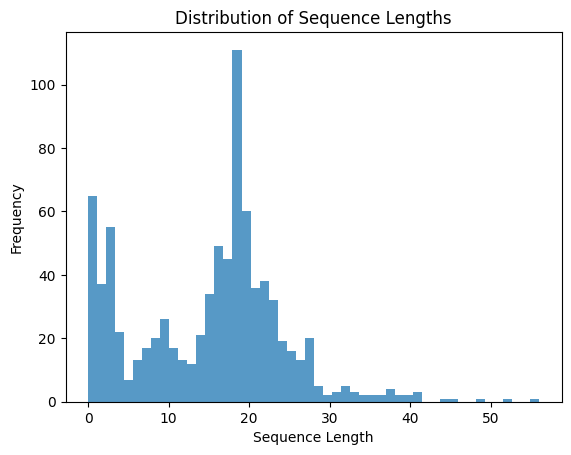

Map:   0%|          | 0/12859 [00:00<?, ? examples/s]

AttributeError: 'list' object has no attribute 'lower'

In [35]:
# Test on larger text
import re
import collections
from collections import Counter, defaultdict
import json


class TrieNode:
    def __init__(self):
        self.children = {}
        self.token_id = None
        self.frequency = 0
        self.failure_link = None
        self.is_end = False  # Add is_end attribute to mark the end of a word
        self.token = None  # Add token attribute to store the token associated with the node


class Trie:
    def __init__(self, unk_token_id=0):
        self.root = TrieNode()
        self.unk_token_id = unk_token_id

    def insert(self, token, token_id, frequency):
        node = self.root
        for char in token:
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
        node.token_id = token_id
        node.frequency = frequency

    def find_subwords(self, token):
        """Finds the most probable subwords based on frequency."""
        node = self.root
        best_subwords = []

        def dfs(current_node, subword='', collected_subwords=[]):
            if current_node.token_id is not None:
                # Update to correctly calculate total_frequency based on the structure of collected_subwords
                total_frequency = sum(n.frequency for _, _, n in collected_subwords) + current_node.frequency
                probability = current_node.frequency / total_frequency if total_frequency else 0
                collected_subwords.append((subword, probability, current_node))

            for char, next_node in current_node.children.items():
                dfs(next_node, subword + char, list(collected_subwords))  # Create a copy of the list to avoid shared state

        dfs(node)
        best_subwords = sorted(best_subwords, key=lambda x: x[1], reverse=True)
        return [subword for subword, _, _ in best_subwords][:5] or [self.unk_token_id]


    def compute_failure_links(self):
        root = self.root
        root.failure_link = root  # Root's failure link points to itself
        queue = [root]

        while queue:
            current_node = queue.pop(0)

            for char, child_node in current_node.children.items():
                queue.append(child_node)

                # Follow failure link to find the longest suffix for the child_node
                failure_candidate = current_node.failure_link
                while failure_candidate != root and char not in failure_candidate.children:
                    failure_candidate = failure_candidate.failure_link
                child_node.failure_link = failure_candidate.children.get(char, root)


class SimpleSentencePiece:
    def __init__(self, model_type="bpe", vocab_size=30522):
        self.vocab = {}
        self.id_to_subword = {}
        self.unk_token = "[UNK]"
        self.unk_token_id = 0
        self.vocab_size = vocab_size
        self.model = None if model_type == "bpe" else None
        self.model_type = model_type

    def train(self, text):
        if self.model_type == "bpe":
            self.model = BPE(num_merges=self.vocab_size, unk_token_id=self.unk_token_id)
            self.model.train(text)
            self.vocab = self.model.vocab
            self.id_to_subword = {i: word for word, i in self.vocab.items()}
        else:
            raise NotImplementedError(f"Model type {self.model_type} not supported yet.")

    def encode(self, text):
        text = self.preprocess_text(text)  # Preprocess text before encoding
        if not self.model:
            raise ValueError("Model has not been trained yet.")
        encoded = self.model.encode(text)
        print(f"Encoded: {encoded[:10]}")  # Print first 10 encoded tokens
        return encoded

    def decode(self, ids):
        if not self.id_to_subword:
            raise ValueError("Vocabulary is empty. Ensure the model is trained first.")
        text = " ".join([self.id_to_subword.get(id_, self.unk_token) for id_ in ids])
        text = text.replace(" </w>", "").replace("</w>", " ").strip()
        return text

    def preprocess_text(self, text):
        # Convert text to lowercase to ensure case insensitivity
        text = text.lower()
        # Optionally, handle punctuation by adding spaces around it for better tokenization
        text = re.sub(r'([.,!?()])', r' \1 ', text)
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text)
        # Trim leading and trailing spaces
        text = text.strip()
        return text
    
    def save_model(self, filepath):
        model_data = {
            'vocab': self.vocab,
            'id_to_subword': self.id_to_subword,
            'model_type': self.model_type,
            'vocab_size': self.vocab_size,
            # Potentially include other relevant attributes
        }
        # Save the high-level tokenizer settings
        with open(filepath, 'w') as f:
            json.dump(model_data, f)
        
        # Now save the BPE model specifically
        if self.model_type == "bpe" and self.model:
            self.model.save_model(filepath + "_bpe")

    def load_model(self, filepath):
        with open(filepath, 'r') as f:
            model_data = json.load(f)
        
        self.vocab = model_data['vocab']
        self.id_to_subword = model_data['id_to_subword']
        self.model_type = model_data['model_type']
        self.vocab_size = model_data['vocab_size']
        
        # Assuming model_type is still "bpe", we now load the BPE model
        if self.model_type == "bpe":
            self.model = BPE(self.vocab_size, self.unk_token_id)
            self.model.load_model(filepath + "_bpe")

class BPE:
    def __init__(self, num_merges=100, unk_token_id=0):  # Accept unk_token_id parameter
        self.vocab = {}
        self.merges = []
        self.num_merges = num_merges
        self.unk_token_id = unk_token_id  # Store the unknown token ID

    def train(self, text):
        words = re.findall(r'\w+|[^\w\s]', text, re.UNICODE)
        vocab = collections.Counter(words)
        vocab = {word + '</w>': count for word, count in vocab.items()}
        
        for _ in range(self.num_merges):  # Use the num_merges from the instance variable
            pairs = self.get_stats(vocab)
            if not pairs:
                break
            best = max(pairs, key=pairs.get)
            vocab = self.merge_vocab(best, vocab)
            self.merges.append(best)

        self.vocab = {word: i for i, word in enumerate(vocab.keys())}

    @staticmethod
    def get_stats(vocab):
        pairs = collections.defaultdict(int)
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols)-1):
                pairs[symbols[i], symbols[i+1]] += freq
        return pairs

    @staticmethod
    def merge_vocab(pair, vocab):
        v_out = {}
        bigram = re.escape(' '.join(pair))
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
        for word in vocab:
            w_out = p.sub(''.join(pair), word)
            v_out[w_out] = vocab[word]
        return v_out

    def encode(self, text):
        """Encode text into subwords using learned BPE merges."""
        encoded_tokens = []
        for word in re.findall(r'\w+|[^\w\s]', text, re.UNICODE):
            word += '</w>'
            subwords = [word]  # Start with the entire word as one subword
            for merge in self.merges:
                new_subwords = []
                for subword in subwords:
                    # If the merge is in subword, split it; otherwise, keep it as is
                    if ' '.join(merge) in subword:
                        new_subwords.extend(subword.replace(' '.join(merge), ''.join(merge)).split(' '))
                    else:
                        new_subwords.append(subword)
                subwords = new_subwords
            encoded_tokens.extend(subwords)
        return [self.vocab.get(token, self.unk_token_id) for token in encoded_tokens]
    
        # New method to save trained model
    def save_model(self, filepath):
        bpe_data = {
            'merges': self.merges,
            'vocab': self.vocab,
            'num_merges': self.num_merges,
            # Include other attributes as needed
        }
        with open(filepath, 'w') as f:
            json.dump(bpe_data, f)

    def load_model(self, filepath):
        with open(filepath, 'r') as f:
            bpe_data = json.load(f)
        
        self.merges = bpe_data['merges']
        self.vocab = bpe_data['vocab']
        self.num_merges = bpe_data['num_merges']



class WordPiece:
    def __init__(self, vocab, unk_token_id=0, unk_token="[UNK]"):
        self.vocab = vocab
        self.unk_token_id = unk_token_id
        self.unk_token = unk_token  # Define the unknown token
        self.root = self.build_trie(vocab)
        self.compute_failure_links(self.root)
        print("Trie built successfully.")

    # Add debug prints to build_trie to confirm structure
    def build_trie(self, vocab):
        root = TrieNode()
        for token in vocab:
            node = root
            for char in token:
                if char not in node.children:
                    node.children[char] = TrieNode()
                node = node.children[char]
            node.is_end = True
            node.token = token
        print("Trie Construction Completed Successfully")
        return root


    def compute_failure_links(self, root):
        queue = [root]
        while queue:
            current_node = queue.pop(0)
            for char, child_node in current_node.children.items():
                failure_node = current_node.failure_link
                while failure_node and char not in failure_node.children:
                    failure_node = failure_node.failure_link
                child_node.failure_link = failure_node.children[char] if failure_node else root
                queue.append(child_node)

    # Improved debug prints in tokenize method
                
    def tokenize(self, text):
        # Preprocess input text
        text = self.preprocess_text(text)
        node = self.root
        token_ids = []  # Will store token IDs instead of tokens
        i = 0

        while i < len(text):
            char = text[i]
            if char == ' ':
                node = self.root
                i += 1
                continue

            if char not in node.children:
                if node != self.root and node.token is not None:
                    # Convert found token to its ID
                    token_id = self.vocab.get(node.token, self.unk_token_id)
                    token_ids.append(token_id)
                    node = self.root  # Reset to root
                    continue
                else:
                    # Append unknown token ID
                    token_ids.append(self.unk_token_id)
                    i += 1
                    continue

            node = node.children[char]
            if node.is_end:
                if i + 1 == len(text) or text[i + 1] == ' ':
                    # Convert found token to its ID
                    token_id = self.vocab.get(node.token, self.unk_token_id)
                    token_ids.append(token_id)
                    node = self.root

            i += 1

        print(f"Token IDs: {token_ids[:10]}")
        return token_ids
    '''
    
    def tokenize(self, text):
        # Preprocess input text
        text = self.preprocess_text(text)
        node = self.root
        tokens = []
        i = 0

        while i < len(text):
            char = text[i]
            if char == ' ':
                node = self.root
                i += 1
                continue

            if char not in node.children:
                if node != self.root:
                    tokens.append(node.token)  # Add the longest token found
                    node = self.root  # Reset to root
                    continue
                else:
                    tokens.append(self.unk_token)
                    i += 1
                    continue

            node = node.children[char]
            if node.is_end:
                if i + 1 == len(text) or text[i + 1] == ' ':
                    tokens.append(node.token)
                    node = self.root

            i += 1
        tokens = [token if token is not None else self.unk_token_id for token in tokens]

        print(f"Tokenized: {tokens[:10]}")
        return tokens
    '''
    def preprocess_text(self, text):
        # Convert text to lowercase to ensure case insensitivity
        text = text.lower()

        # Optionally, handle punctuation by adding spaces around it for better tokenization
        # This depends on how your vocabulary handles punctuation
        text = re.sub(r'([.,!?()])', r' \1 ', text)

        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text)

        # Trim leading and trailing spaces
        text = text.strip()

        return text


def load_corpus(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        texts = [line.strip() for line in file.readlines()]
    return texts

#texts = load_corpus("D:\\EXPERT_WEIGHTS\\sample.txt")
texts = load_corpus("C:/Users/robbi/Expert/sample.txt")
num_merges = 100

# Initialize and train the SimpleSentencePiece model with BPE
ssp = SimpleSentencePiece(model_type="bpe", vocab_size=30522)
ssp.train('\n'.join(texts))  # Train the model on the entire dataset

# Test the model on a subset or the entire dataset
for i, text in enumerate(texts[:10]):  # Example: test on the first 100 texts
    encoded = ssp.encode(text)
    decoded = ssp.decode(encoded)
    print(f"Original: {text}")
    print(f"Decoded: {decoded}\n")

# Save the trained model
ssp.save_model("ssp_model.json")

# Create a new instance and load the model
new_ssp = SimpleSentencePiece(model_type="bpe")
new_ssp.load_model("ssp_model.json")

# New Model
for i, text in enumerate(texts[:10]):  # Example: test on the first 100 texts
    re_encoded = ssp.encode(text)
    re_decoded = ssp.decode(re_encoded)
    print(f"Original: {text}")
    print(f"Decoded: {re_decoded}\n")


# Assuming ssp is your SimpleSentencePiece instance
vocab = ssp.vocab  # This gets the vocabulary after BPE training
new_vocab = new_ssp.vocab  # This gets the vocabulary after BPE training

print(f"vocab ; {len(vocab)} , new_vocab: {len(new_vocab)}")

def adapt_vocab_for_wordpiece(ssp_vocab):
    adapted_vocab = {}
    for token, id_or_freq in ssp_vocab.items():
        # Check if a token is a continuation subword and not a standalone word
        # Since BPE might not mark subwords in a way WordPiece expects, we adapt based on our best approximation
        if not token.startswith(" ") and not token.endswith("</w>"):
            adapted_token = "##" + token.replace("</w>", "")  # Removing BPE's end-of-word marker and prepending "##"
        else:
            adapted_token = token.replace("</w>", "")  # Just remove the BPE's end-of-word marker for standalone words

        adapted_vocab[adapted_token] = id_or_freq
    return adapted_vocab


# Assuming ssp is your SimpleSentencePiece instance after BPE training
wordpiece_vocab = adapt_vocab_for_wordpiece(ssp.vocab)

# Debugging step to ensure vocabulary completeness
def debug_vocab(adapted_vocab):
    print("Sample Vocabulary Check:")
    # Iterate over the first 10 key-value pairs in the adapted vocabulary
    for i, (token, id_or_freq) in enumerate(adapted_vocab.items()):
        print(f"{token}: {id_or_freq}")
        if i >= 9:  # Stop after printing 10 entries
            break
    # Specifically check for subtokens if your tokenizer expects them
    subtokens = [token for token in adapted_vocab.keys() if token.startswith("##")]
    print(f"Found {len(subtokens)} subtokens in vocabulary.")


# Ensure wordpiece_vocab is a list of vocabulary tokens
debug_vocab(wordpiece_vocab)  # Call this after initializing wordpiece_vocab


# Load your WordPiece tokenizer
# wordpiece_tokenizer = WordPiece(wordpiece_vocab)  # Assuming wordpiece_vocab is your BPE-trained vocabulary

# Initialize WordPiece with the adapted vocabulary
wordpiece_tokenizer = WordPiece(wordpiece_vocab, unk_token_id=0, unk_token="[UNK]")

for i, text in enumerate(texts[:10]):
    print(f"Testing ': {text}")
    tokenized = wordpiece_tokenizer.tokenize(text)
    print(f"Tokenized: {tokenized}\n")

# Token Sequence Length Testing
'''
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def calculate_sequence_lengths(texts, tokenizer):
    lengths = [len(tokenizer.tokenize(text)) for text in texts]
    return lengths

# Assuming `texts` is a list of all sequences in your dataset
# and `wordpiece_tokenizer` is your tokenizer instance
sequence_lengths = calculate_sequence_lengths(texts, wordpiece_tokenizer)

# Analyze length distribution
length_counter = Counter(sequence_lengths)
print("Mean length:", np.mean(sequence_lengths))
print("Median length:", np.median(sequence_lengths))
print("95th percentile length:", np.percentile(sequence_lengths, 95))
print("99th percentile length:", np.percentile(sequence_lengths, 99))

# Visualize the distribution of sequence lengths
plt.hist(sequence_lengths, bins=50, alpha=0.75)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()
'''

# Modify the preprocess_dpo_data function to use your WordPiece tokenizer
    
def preprocess_dpo_data(examples, tokenizer, max_length):
    # Tokenize fields
    tokenized_questions = tokenizer.tokenize(examples['question'])
    tokenized_chosen = tokenizer.tokenize(examples['chosen'])
    tokenized_rejected = tokenizer.tokenize(examples['rejected'])

    # Pad tokenized sequences to ensure they all have the same length
    desired_length = 1000  # or any other length suitable for your model
    tokenized_questions = tokenized_questions[:desired_length] + [0] * (desired_length - len(tokenized_questions))
    tokenized_chosen = tokenized_chosen[:desired_length] + [0] * (desired_length - len(tokenized_chosen))
    tokenized_rejected = tokenized_rejected[:desired_length] + [0] * (desired_length - len(tokenized_rejected))

    # Generate labels (ensure labels are correctly sized if they are used here)
    labels = [1 if i % 2 == 0 else 0 for i in range(desired_length)]  # Adjust as needed for your application
    
    print(f"Type of tokenized questions: {type(tokenized_questions)}, Length: {len(tokenized_questions)}")
    print(f"Type of tokenized chosen: {type(tokenized_chosen)}, Length: {len(tokenized_chosen)}")
    print(f"Type of tokenized rejected: {type(tokenized_rejected)}, Length: {len(tokenized_rejected)}")
    print(f"First 5 tokens of tokenized questions: {tokenized_questions[:5]}")
    print(f"tokenized questions length: {len(tokenized_questions)}")
    print(f"tokenized chosen length: {len(tokenized_chosen)}")
    print(f"tokenized_rejected length: {len(tokenized_rejected)}")
    print(f"Labels Length: {len(labels)}")

    return {
        'input_ids_question': tokenized_questions,
        'input_ids_chosen': tokenized_chosen,
        'input_ids_rejected': tokenized_rejected,
        'labels': labels
    }

'''
def preprocess_dpo_data(examples, tokenizer, max_length):
    # Ensure 'question', 'chosen', and 'rejected' fields are strings
    question = " ".join(examples['question']) if isinstance(examples['question'], list) else examples['question']
    chosen = " ".join(examples['chosen']) if isinstance(examples['chosen'], list) else examples['chosen']
    rejected = " ".join(examples['rejected']) if isinstance(examples['rejected'], list) else examples['rejected']

    # Tokenize 'question', 'chosen', and 'rejected' fields using your WordPiece tokenizer
    tokenized_questions = tokenizer.tokenize(question)
    tokenized_chosen = tokenizer.tokenize(chosen)
    tokenized_rejected = tokenizer.tokenize(rejected)

    # Truncate or pad the tokenized sequences to the specified max_length
    tokenized_questions = tokenized_questions[:max_length]  # Truncate if longer than max_length
    tokenized_questions += [0] * (max_length - len(tokenized_questions))  # Pad to max_length
    tokenized_chosen = tokenized_chosen[:max_length]  # Truncate if longer than max_length
    tokenized_chosen += [0] * (max_length - len(tokenized_chosen))  # Pad to max_length
    tokenized_rejected = tokenized_rejected[:max_length]  # Truncate if longer than max_length
    tokenized_rejected += [0] * (max_length - len(tokenized_rejected))  # Pad to max_length

    # Ensure that the length of the labels matches the length of the tokenized sequences
    labels_length = len(tokenized_questions)  # Use the length of the tokenized sequences as the labels length
    labels = [1 if i % 2 == 0 else 0 for i in range(labels_length)]  # Generate labels with the correct length

    # Pad input_ids_question to the desired length of 1000
    tokenized_questions += [0] * (1000 - len(tokenized_questions))
    # Debugging: Print types and lengths of tokenized sequences
    print(f"Type of tokenized questions: {type(tokenized_questions)}, Length: {len(tokenized_questions)}")
    print(f"Type of tokenized chosen: {type(tokenized_chosen)}, Length: {len(tokenized_chosen)}")
    print(f"Type of tokenized rejected: {type(tokenized_rejected)}, Length: {len(tokenized_rejected)}")
    print(f"First 5 tokens of tokenized questions: {tokenized_questions[:5]}")
    print(f"tokenized questions length: {len(tokenized_questions)}")
    print(f"tokenized chosen length: {len(tokenized_chosen)}")
    print(f"tokenized_rejected length: {len(tokenized_rejected)}")
    print(f"Labels Length: {len(labels)}")

    return {
        'input_ids_question': tokenized_questions,
        'input_ids_chosen': tokenized_chosen,
        'input_ids_rejected': tokenized_rejected,
        'labels': labels
    }
'''

# Load the DPO dataset from Hugging Face
dpo_dataset = load_dataset("Intel/orca_dpo_pairs")
max_seq_length = 512 // 3
# Apply the preprocessing to the dataset with your WordPiece tokenizer
dpo_dataset = dpo_dataset.map(lambda x: preprocess_dpo_data(x, wordpiece_tokenizer, max_seq_length), batched=True)


# You can convert to PyTorch tensors after processing
dpo_dataset.set_format(type='torch', columns=['input_ids_question', 'attention_mask_question', 'input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected', 'labels'])

train_loader = DataLoader(dpo_dataset['train'], batch_size=2, shuffle=True)

# Instantiate the Expert model and optimizer
config = ExpertConfig()
expert_model = Expert(config)

model_vocab_size = expert_model.lmt.decoder.word_embedding.num_embeddings
print(f"Model vocab size: {model_vocab_size}")
print(f"Model embedding size: {expert_model.lmt.decoder.word_embedding.embedding_dim}")
print(f"Configured max length: {config.max_length}")

optimizer = AdamW(expert_model.parameters(), lr=1e-5)
#save_path = 'D:/EXPERT_WEIGHTS/dpo_model.pth'

# Train the DPO model
label_column = 'labels'
input_columns = ['input_ids_question', 'attention_mask_question', 'input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected']
# Assuming expert_model is an instance of Expert
avg_loss = expert_model.train_dpo(train_loader, optimizer, config, save_path)

# Save the model
#torch.save(expert_model.transformer_dpo.state_dict(), save_path)





# Train RAG

In [ ]:
# Instantiate the Expert model and optimizer
config = ExpertConfig()

# Initialize Expert system
expert_system = Expert(config)
sequence_length = 30 
# Load dataset
dataset = load_dataset('wikipedia', '20220301.simple')

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
vocab_size = tokenizer.vocab_size

def tokenize_function(examples):
    # Tokenize the text
    tokenized_output = tokenizer(examples['text'], padding='max_length', truncation=True, max_length=sequence_length)
    
    # Shift input_ids to create labels and truncate the last token
    labels = [seq[1:] + [tokenizer.pad_token_id] for seq in tokenized_output['input_ids']]
    tokenized_output['labels'] = labels
    
    return tokenized_output

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_loader = DataLoader(tokenized_datasets['train'], batch_size=64, shuffle=True)

# Rag data
train_rag_data = {
    "queries": [
        # Queries for DPO.pdf
        "What is Direct Preference Optimization (DPO)?",
        "How does Direct Preference Optimization work?",
        "How can I implement Direct Preference Optimization in my organization?",
        "Why does Direct Preference Optimization improve the efficiency of language modelling?",
        # Queries for MAMBA.pdf
        "What is MAMBA?",
        "How does MAMBA function?",
        "How can I build a system based on MAMBA technology?",
        "Why does MAMBA enhance the performance of its application area?",
        # Queries for QLORA.pdf
        "What is QLORA?",
        "How does QLORA operate?",
        "How can I develop a project using QLORA?",
        "Why does QLORA improve the capabilities of its relevant field?",
        # Queries for RAG.pdf
        "What is Retrieval Augmented Generation (RAG)?",
        "How does Retrieval Augmented Generation work?",
        "How can I build a Retrieval Augmented Generation model?",
        "Why does Retrieval Augmented Generation enhance language model performance?",
        # Queries for SWITCH_TRANSFORMER.pdf
        "What is the Switch Transformer model?",
        "How does the Switch Transformer model operate?",
        "How can I construct a Switch Transformer model?",
        "Why does the Switch Transformer model improve language processing tasks?"
    ],
    "contexts": [
        # Contexts from DPO.pdf
        config.rag_dataset['train'][0],  # Assuming dataset[0] is the processed content of DPO.pdf
        config.rag_dataset['train'][0],
        config.rag_dataset['train'][0],
        config.rag_dataset['train'][0],
        # Contexts from MAMBA.pdf
        config.rag_dataset['train'][1],  # Assuming dataset[1] is the processed content of MAMBA.pdf
        config.rag_dataset['train'][1],
        config.rag_dataset['train'][1],
        config.rag_dataset['train'][1],
        # Contexts from QLORA.pdf
        config.rag_dataset['train'][2],  # Assuming dataset[2] is the processed content of QLORA.pdf
        config.rag_dataset['train'][2],
        config.rag_dataset['train'][2],
        config.rag_dataset['train'][2],
        # Contexts from RAG.pdf
        config.rag_dataset['train'][3],  # Assuming dataset[3] is the processed content of RAG.pdf
        config.rag_dataset['train'][3],
        config.rag_dataset['train'][3],
        config.rag_dataset['train'][3],
        # Contexts from SWITCH_TRANSFORMER.pdf
        config.rag_dataset['train'][4],  # Assuming dataset[4] is the processed content of SWITCH_TRANSFORMER.pdf
        config.rag_dataset['train'][4],
        config.rag_dataset['train'][4],
        config.rag_dataset['train'][4]
    ]
}


# Train the LMT_Rag sub-model within the Expert system
# Train th model
model, average_loss = expert_system.train_language_model_rag(
    expert_system.transformer_rag,  # Assuming transformer_rag is your RAG model within Expert
    config.rag_model_path,
    train_loader,
    device = config.device,
    num_epochs=5,
    lr=1e-5,  # Adjust learning rate as needed
    weight_decay=1e-4
)

# Train DPR encoders
(context_encoder, question_encoder), average_loss = expert_system.train_dpr_encoders(
    train_rag_data,
    expert_system.context_encoder,  # Assuming you have these initialized within Expert
    expert_system.question_encoder,
    optimizer_context = AdamW(expert_system.context_encoder.parameters(), lr=1e-5),  
    optimizer_question = AdamW(expert_system.question_encoder.parameters(), lr=1e-5),
    epochs=5,
    context_save_path=config.context_encoder_path,
    question_save_path=config.question_encoder_path
)

# Train MAMBA

In [ ]:
# Instantiate the Expert model and optimizer
config = ExpertConfig()

# Initialize Expert system
expert_system = Expert(config)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = load_dataset('wikipedia', '20220301.simple')

def tokenize_function(examples):
    # Tokenize the text
    tokenized_output = tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)
    
    # Convert lists to PyTorch tensors
    input_ids = torch.tensor(tokenized_output['input_ids']).to(config.device)
    attention_mask = torch.tensor(tokenized_output['attention_mask']).to(config.device)

    # Creating labels by shifting the input_ids
    labels = input_ids[:, :-1].clone().to(config.device)
    labels = torch.nn.functional.pad(labels, (0, 1), value=tokenizer.pad_token_id)  # Pad labels to match sequence length
    
    tokenized_output['input_ids'] = input_ids
    tokenized_output['attention_mask'] = attention_mask
    tokenized_output['labels'] = labels

    return tokenized_output


tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


# DataLoader - same as your working code
train_loader = DataLoader(tokenized_datasets['train'], batch_size=8, shuffle=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


# DataLoader - same as your working code
train_loader = DataLoader(tokenized_datasets['train'], batch_size=8, shuffle=True)


expert_system.train_mamba(train_loader, 5, config)

# Train Whole Expert

In [ ]:
# Instantiate the Expert model and Data
config = ExpertConfig()

# Initialize Expert system
expert_system = Expert(config)

# Load Wikipedia dataset and preprocess
dataset = load_dataset("wikipedia", "20220301.en", split="train[:1%]")  # Using 1% of the data for demonstration

def tokenize_function(examples):
    tokenizer = BertTokenizer.from_pretrained(config.tokenizer_name)
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=config.max_length)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])  # Remove original text to only keep tokenized versions
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask'])


main_loss_function = torch.nn.CrossEntropyLoss()
aux_loss_weight = 0.1  # Adjust based on the significance of the auxiliary loss in your training

optimizer = torch.optim.AdamW(expert_model.parameters(), lr=1e-5, weight_decay=1e-4)

# Rag data
train_rag_data = {
    "queries": [
        # Queries for DPO.pdf
        "What is Direct Preference Optimization (DPO)?",
        "How does Direct Preference Optimization work?",
        "How can I implement Direct Preference Optimization in my organization?",
        "Why does Direct Preference Optimization improve the efficiency of language modelling?",
        # Queries for MAMBA.pdf
        "What is MAMBA?",
        "How does MAMBA function?",
        "How can I build a system based on MAMBA technology?",
        "Why does MAMBA enhance the performance of its application area?",
        # Queries for QLORA.pdf
        "What is QLORA?",
        "How does QLORA operate?",
        "How can I develop a project using QLORA?",
        "Why does QLORA improve the capabilities of its relevant field?",
        # Queries for RAG.pdf
        "What is Retrieval Augmented Generation (RAG)?",
        "How does Retrieval Augmented Generation work?",
        "How can I build a Retrieval Augmented Generation model?",
        "Why does Retrieval Augmented Generation enhance language model performance?",
        # Queries for SWITCH_TRANSFORMER.pdf
        "What is the Switch Transformer model?",
        "How does the Switch Transformer model operate?",
        "How can I construct a Switch Transformer model?",
        "Why does the Switch Transformer model improve language processing tasks?"
    ],
    "contexts": [
        # Contexts from DPO.pdf
        config.rag_dataset['train'][0],  # Assuming dataset[0] is the processed content of DPO.pdf
        config.rag_dataset['train'][0],
        config.rag_dataset['train'][0],
        config.rag_dataset['train'][0],
        # Contexts from MAMBA.pdf
        config.rag_dataset['train'][1],  # Assuming dataset[1] is the processed content of MAMBA.pdf
        config.rag_dataset['train'][1],
        config.rag_dataset['train'][1],
        config.rag_dataset['train'][1],
        # Contexts from QLORA.pdf
        config.rag_dataset['train'][2],  # Assuming dataset[2] is the processed content of QLORA.pdf
        config.rag_dataset['train'][2],
        config.rag_dataset['train'][2],
        config.rag_dataset['train'][2],
        # Contexts from RAG.pdf
        config.rag_dataset['train'][3],  # Assuming dataset[3] is the processed content of RAG.pdf
        config.rag_dataset['train'][3],
        config.rag_dataset['train'][3],
        config.rag_dataset['train'][3],
        # Contexts from SWITCH_TRANSFORMER.pdf
        config.rag_dataset['train'][4],  # Assuming dataset[4] is the processed content of SWITCH_TRANSFORMER.pdf
        config.rag_dataset['train'][4],
        config.rag_dataset['train'][4],
        config.rag_dataset['train'][4]
    ]
}


# Train the model
trained_expert_model, average_loss = expert_model.train_expert(
    train_loader=train_loader,
    train_data=train_rag_data,
    optimizer=optimizer,
    main_loss_function=main_loss_function,
    aux_loss_weight=aux_loss_weight,
    device=config.device,
    save_path=save_path,
    accumulation_steps=4,  # Adjust based on your preference
    num_epochs=5  # Adjust based on your training needs
)

print(f"Training completed. Average loss: {average_loss}")

# Integrating Encoding and Decoding

In [ ]:
import torch
import torch.nn as nn
import pickle

class Expert(nn.Module):
    def __init__(self, config: ExpertConfig):
        super(Expert, self).__init__()

        # Initialize components for other functionalities (e.g., RAG, DPO, MAMBA)
        self.rag = self._initialize_rag(config)
        self.dpo = self._initialize_dpo(config)
        self.mamba = self._initialize_mamba(config)
        

        # Initialize other necessary layers or parameters
        self.dropout = nn.Dropout(config.dropout)
        self.layer_norm = nn.LayerNorm(config.input_dim)

        # Load the custom Transformer model
        self.custom_transformer = TransformerModel(
            vocab=config.vocab,  # Assuming vocab is part of config
            vocab_size=config.actual_vocab_size,
            embedding_dim=128,
            max_seq_len=512,
            nhead=8,
            dim_feedforward=2048,
            freq_threshold=config.freq_threshold,
            smaller_embed_dim=64
        )
        self.custom_transformer.load_state_dict(torch.load(config.transformer_model_path))
        self.custom_transformer.eval()

        # Load the custom tokenizer
        with open(config.tokenizer_path, 'rb') as f:
            self.custom_tokenizer = pickle.load(f)

    def _initialize_rag(self, config):
        # Placeholder for initializing the RAG model component
        # This would typically involve loading a model and its weights
        return None  # Replace with actual initialization

    def _initialize_dpo(self, config):
        # Placeholder for initializing the DPO model component
        return None  # Replace with actual initialization

    def _initialize_mamba(self, config):
        # Placeholder for initializing the MAMBA model component
        return None  # Replace with actual initialization

    def forward(self, input_text):
        # Example forward pass using the custom transformer and tokenizer
        
        # Tokenize the input text
        tokenized_input = self.custom_tokenizer.encode(input_text)  # Assuming a method that returns token IDs
        tokenized_input = torch.tensor(tokenized_input).unsqueeze(0)  # Add batch dimension
        
        # Pass the tokenized input through the custom transformer
        with torch.no_grad():
            output_logits, _ = self.custom_transformer(tokenized_input)

        # Further processing based on output_logits
        # For example, applying softmax to get probabilities for classification tasks
        return output_logits

# Assuming ExpertConfig is defined elsewhere with the necessary attributes
